# Compare classifiers across consensus profiles

Compare classifier metrics across different consensus profile strategies, stratefied by representations types. We also compare all results to the random baseline. 

In [1]:
import polars as pl 
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import MultiComparison

## Seal annotations

In [2]:
seal_preds = pl.read_parquet("./compiled_results/compiled_seal_metrics.parquet")
seal_pandas = seal_preds.filter(pl.col("Model_type") == "Actual").to_pandas()

seal_cpcnn = seal_preds.filter(pl.col("Feat_type") == "cpcnn")
seal_dino = seal_preds.filter(pl.col("Feat_type") == "dino")
seal_cellprofiler = seal_preds.filter(pl.col("Feat_type") == "cellprofiler")

### CPCNN

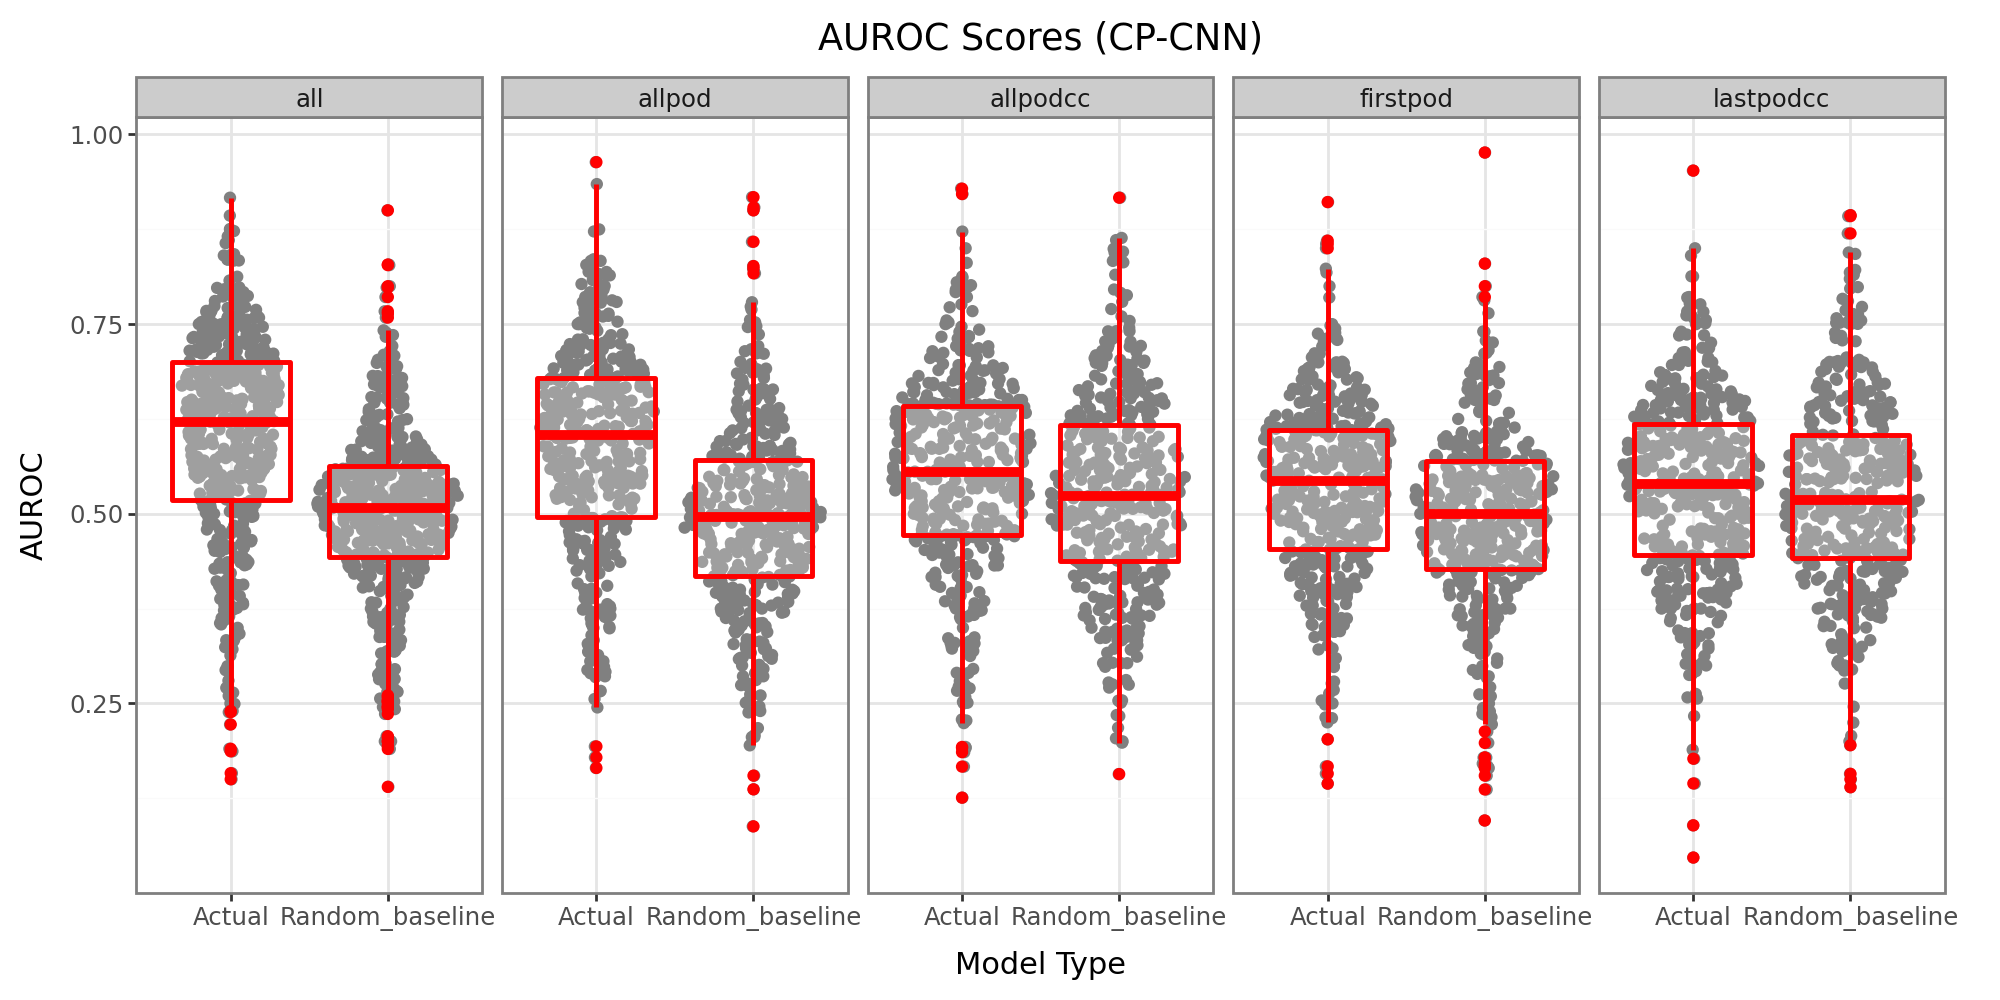

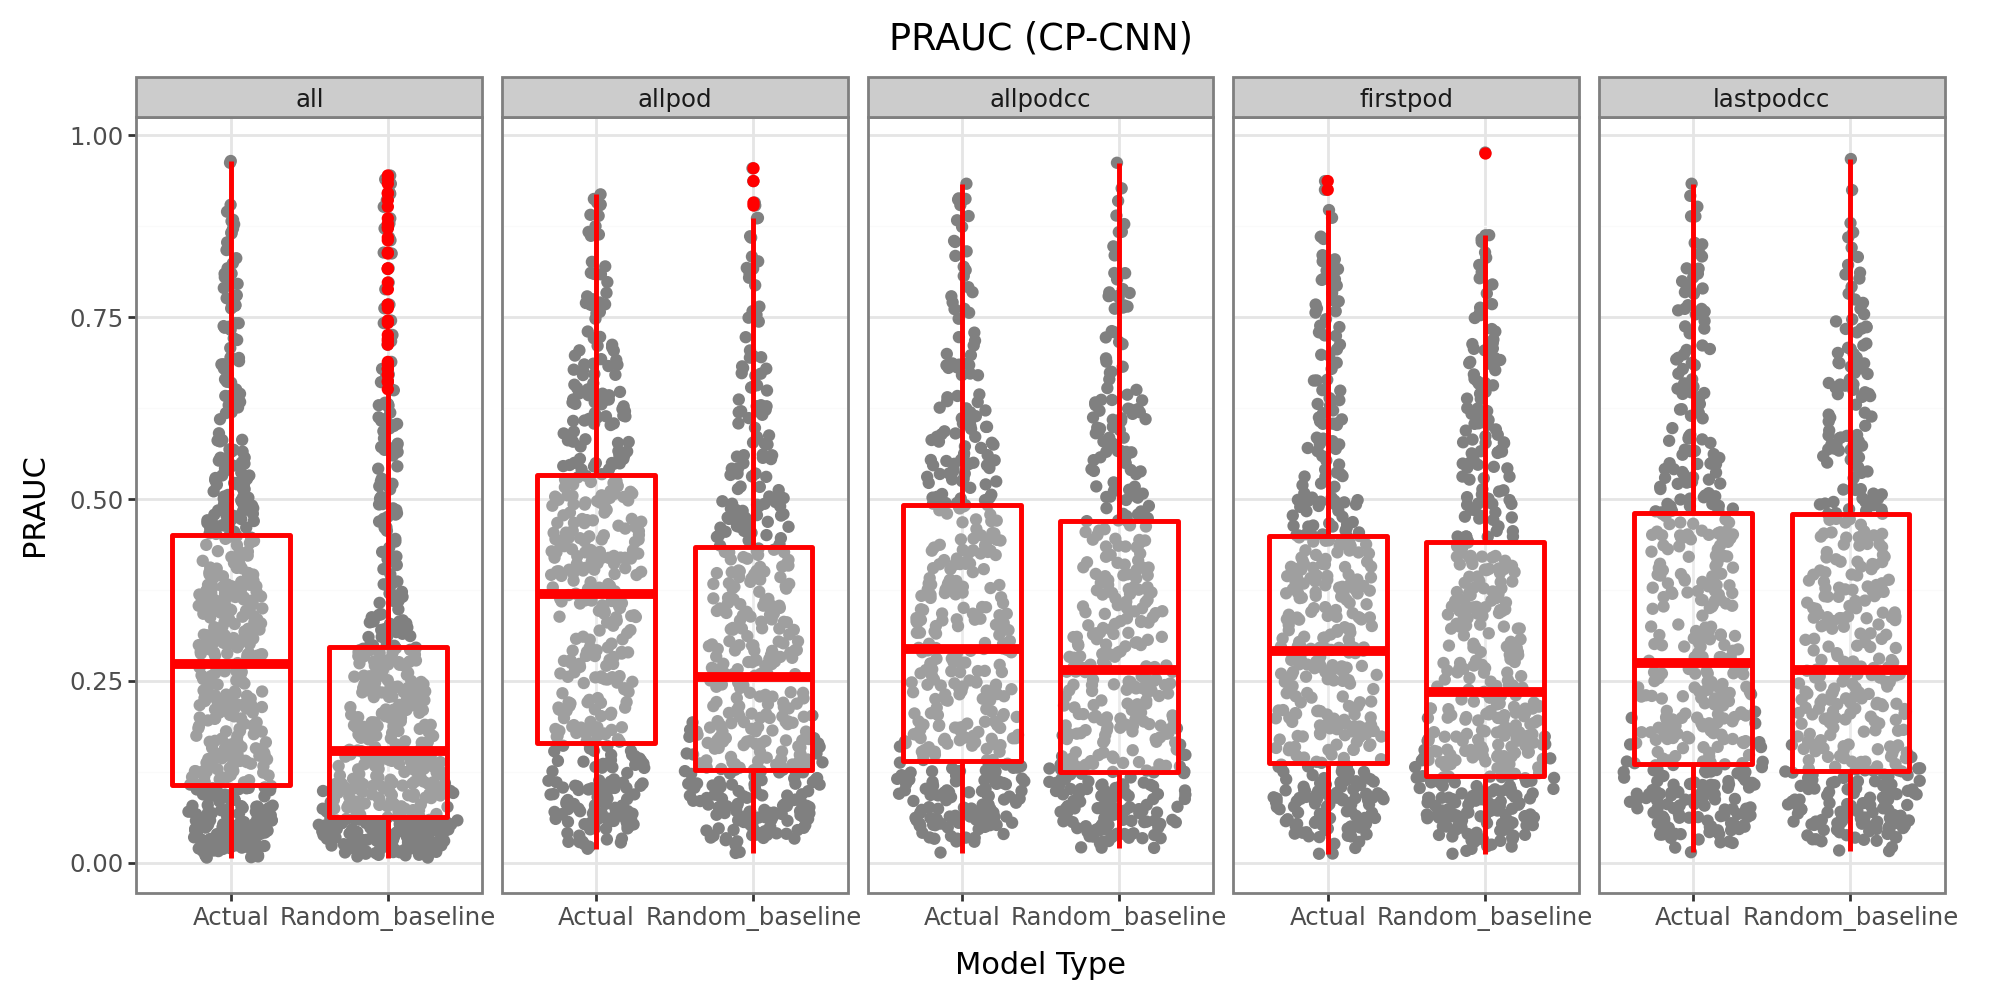

In [13]:
from plotnine import ggplot, aes, geom_sina, geom_boxplot, labs, theme_bw, position_dodge, facet_wrap
import plotnine as pn

pn.options.figure_size = (10, 5)

plot = (
    ggplot(seal_cpcnn, aes(x='Model_type', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + facet_wrap("Metadata_AggType", ncol=5)
    + labs(title='AUROC Scores (CP-CNN)', x='Model Type', y='AUROC') 
    + theme_bw()
)
plot.show()

plot = (
    ggplot(seal_cpcnn, aes(x='Model_type', y='PRAUC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + facet_wrap("Metadata_AggType", ncol=5)
    + labs(title='PRAUC (CP-CNN)', x='Model Type', y='PRAUC') 
    + theme_bw()
)
plot.show()

### Dino

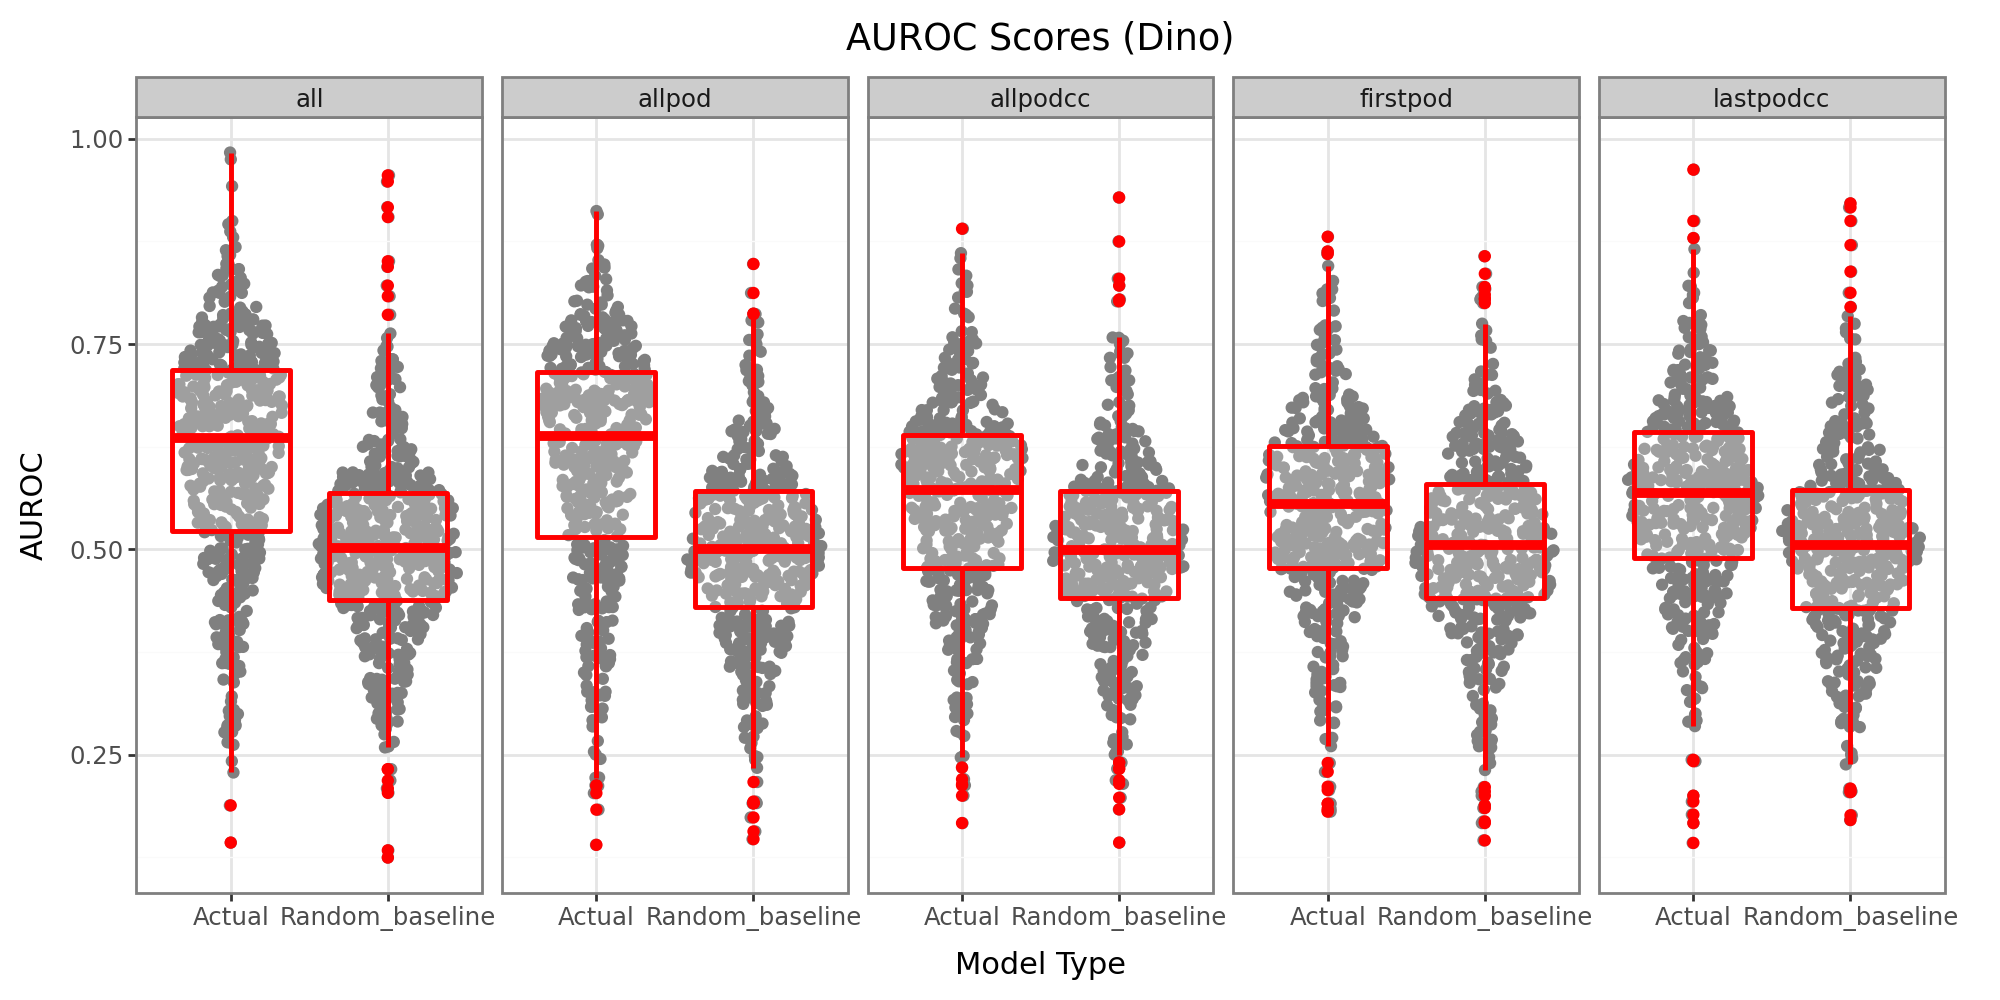

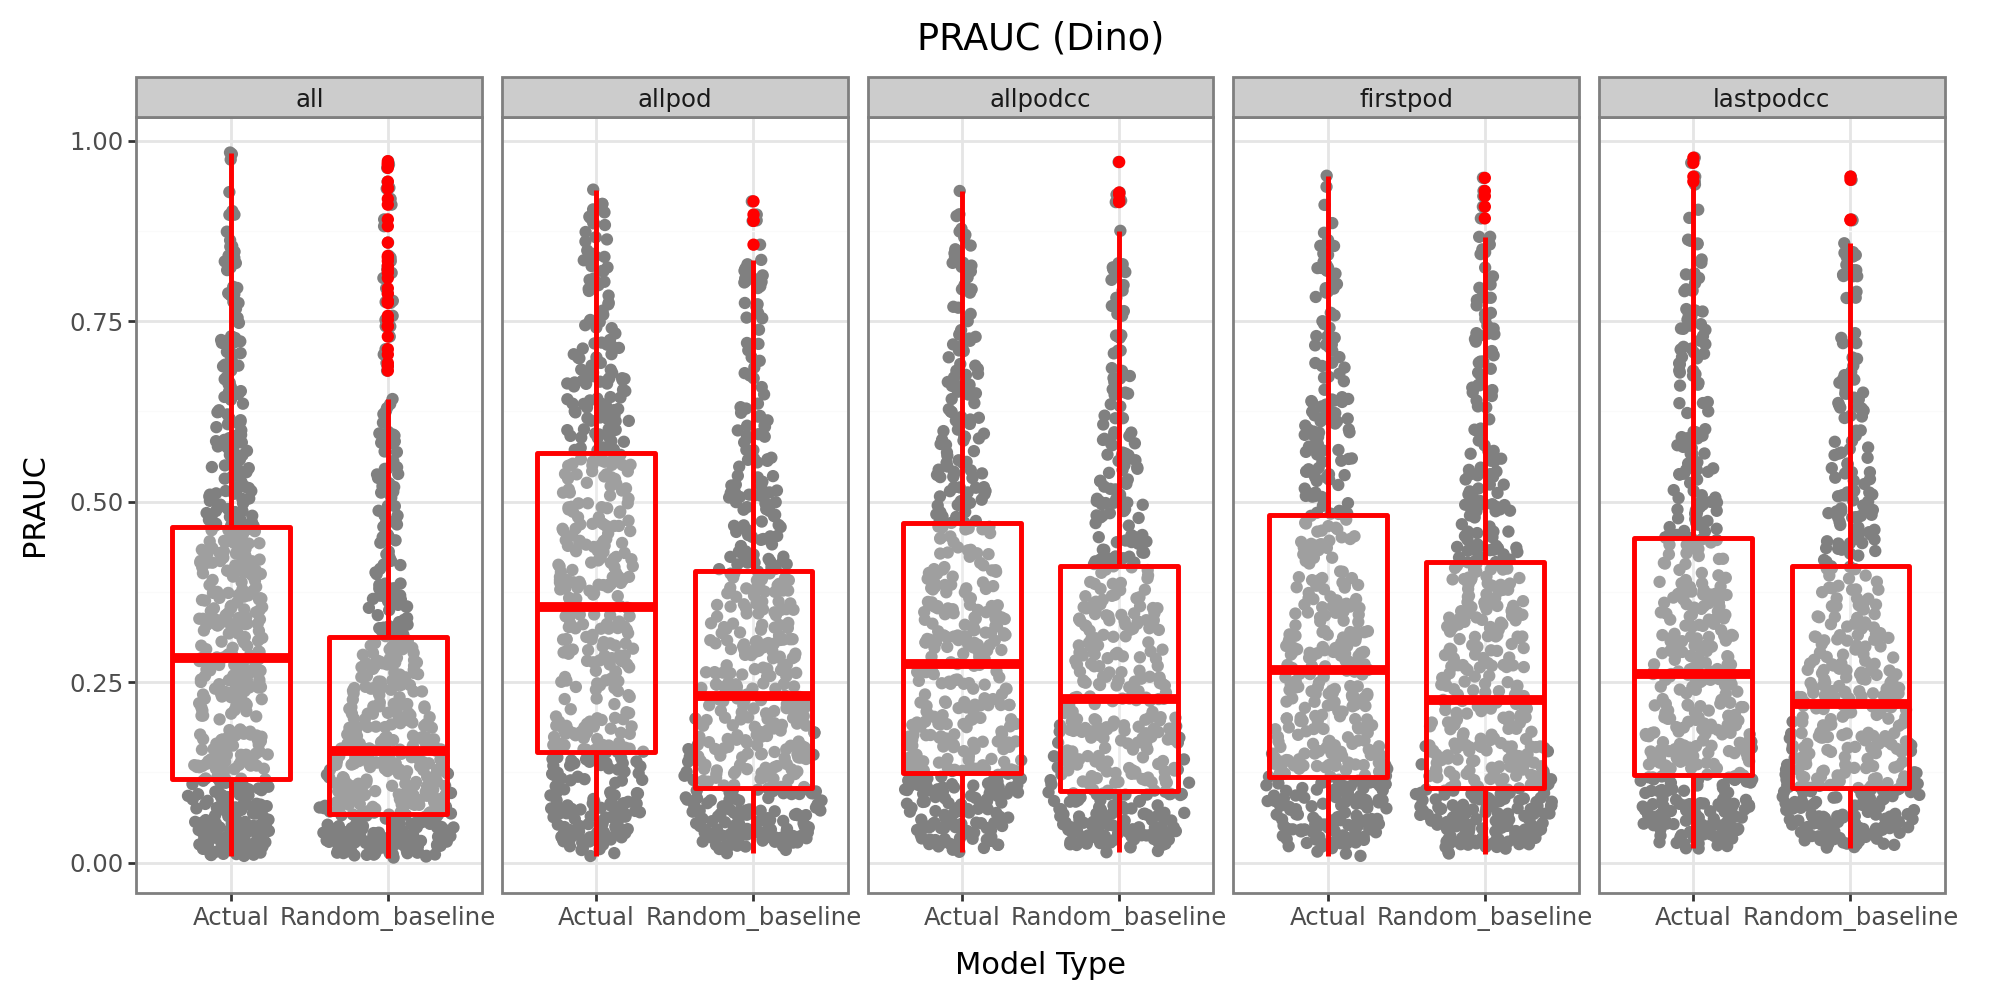

In [14]:
from plotnine import ggplot, aes, geom_sina, geom_boxplot, labs, theme_bw, position_dodge, facet_wrap
import plotnine as pn

pn.options.figure_size = (10, 5)

plot = (
    ggplot(seal_dino, aes(x='Model_type', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + facet_wrap("Metadata_AggType", ncol=5)
    + labs(title='AUROC Scores (Dino)', x='Model Type', y='AUROC') 
    + theme_bw()
)
plot.show()

plot = (
    ggplot(seal_dino, aes(x='Model_type', y='PRAUC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + facet_wrap("Metadata_AggType", ncol=5)
    + labs(title='PRAUC (Dino)', x='Model Type', y='PRAUC') 
    + theme_bw()
)
plot.show()

### CellProfiler

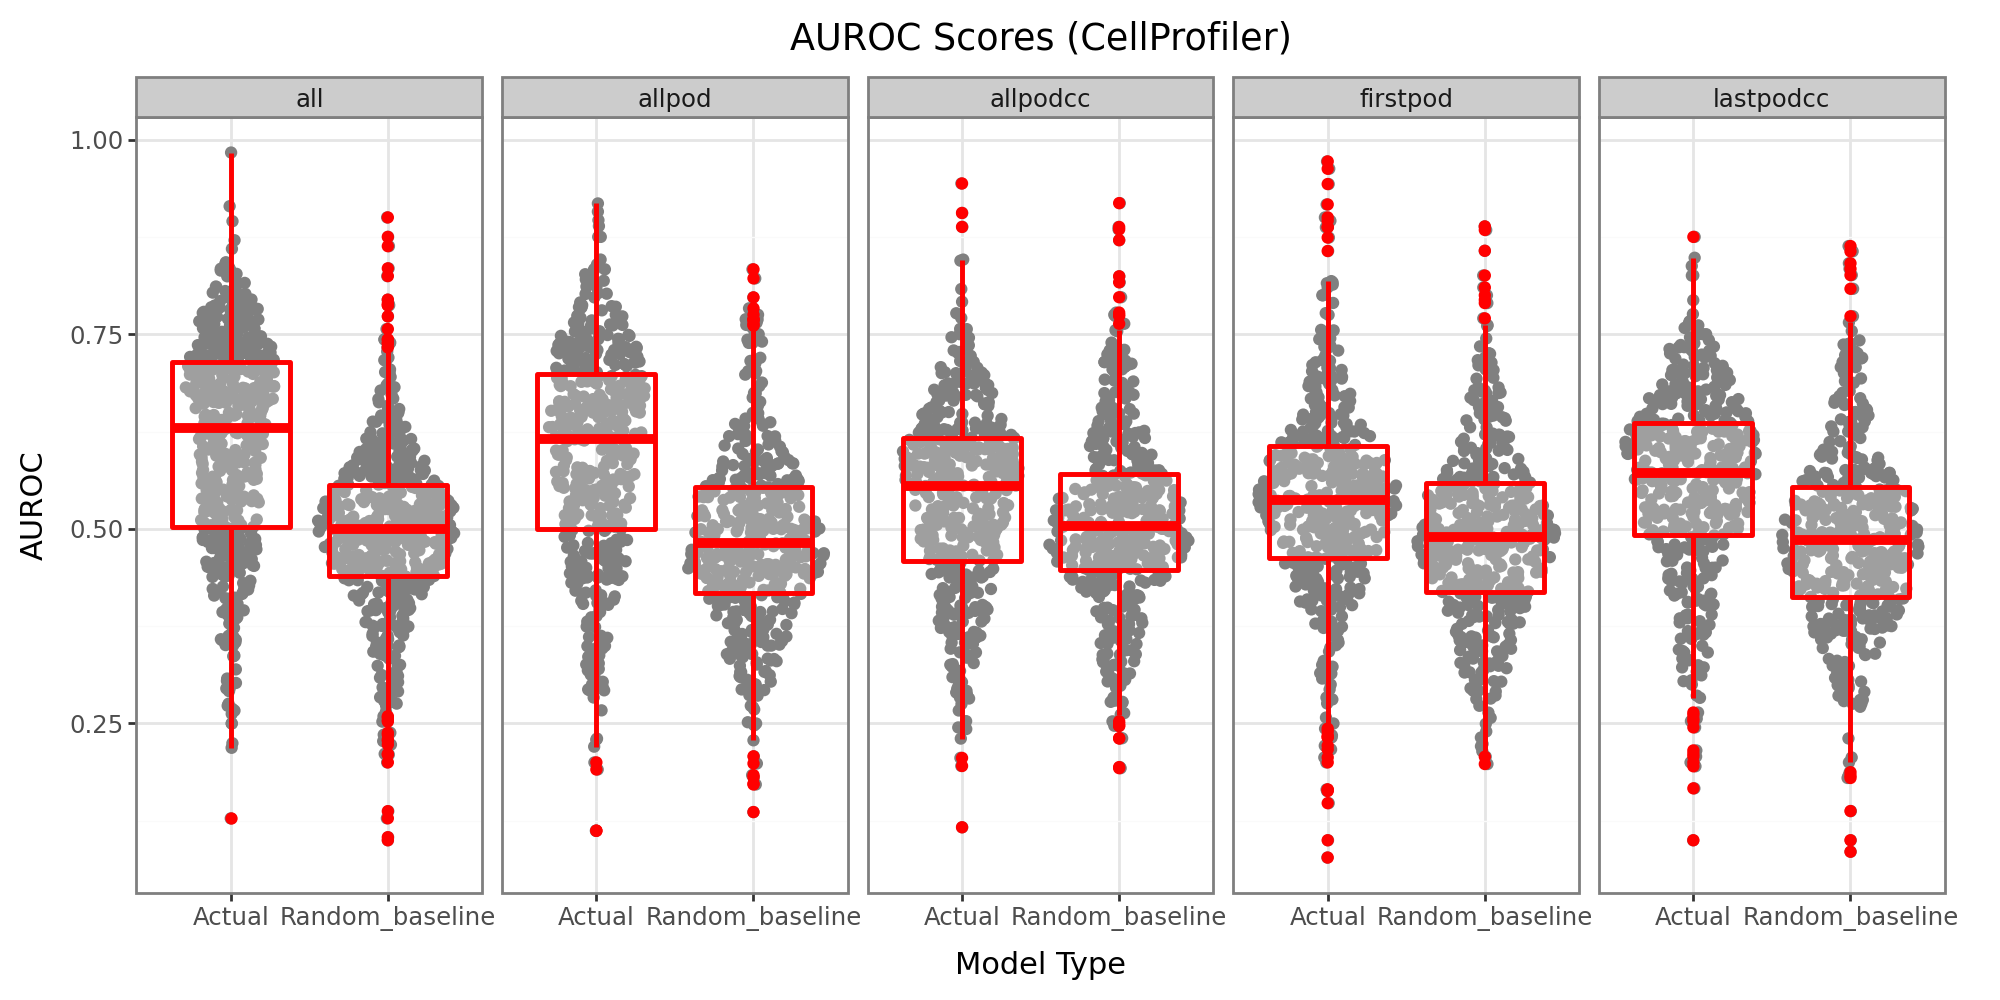

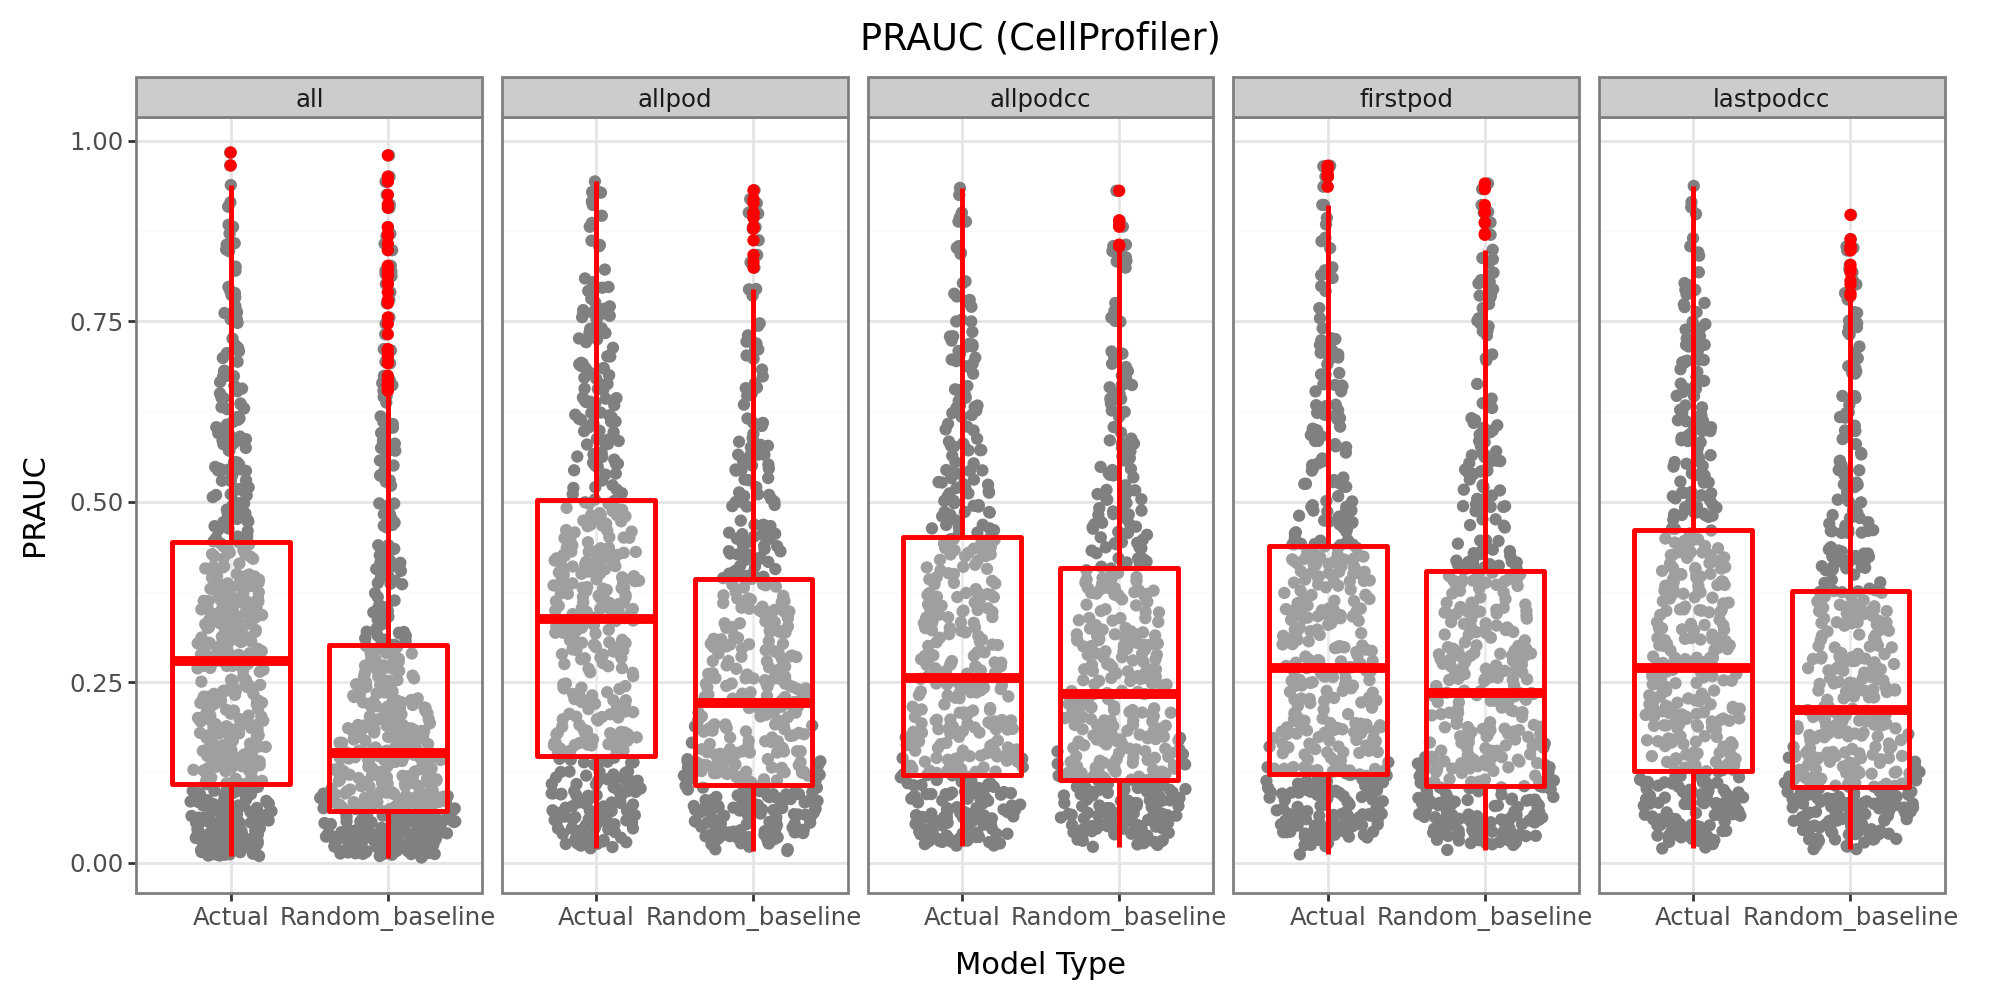

In [15]:
from plotnine import ggplot, aes, geom_sina, geom_boxplot, labs, theme_bw, position_dodge, facet_wrap
import plotnine as pn

pn.options.figure_size = (10, 5)

plot = (
    ggplot(seal_cellprofiler, aes(x='Model_type', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + facet_wrap("Metadata_AggType", ncol=5)
    + labs(title='AUROC Scores (CellProfiler)', x='Model Type', y='AUROC') 
    + theme_bw()
)
plot.show()

plot = (
    ggplot(seal_cellprofiler, aes(x='Model_type', y='PRAUC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + facet_wrap("Metadata_AggType", ncol=5)
    + labs(title='PRAUC (CellProfiler)', x='Model Type', y='PRAUC') 
    + theme_bw()
)
plot.show()

### Split up cytotoxicity assays and remove nonsense assays

In [3]:
assays = seal_cellprofiler.select("Metadata_Label").to_series().unique().to_list()
cytotox = [i for i in assays if any(keyword in i for keyword in ["viability", "SRB", "Proliferation", "Cytotoxicity"])]

not_cytotox = [i for i in assays if i not in cytotox]
not_cytotox = [i for i in not_cytotox if "ch1" not in i]
not_cytotox = [i for i in not_cytotox if "ch2" not in i]
not_cytotox = [i for i in not_cytotox if "ZF" not in i]

hepg2 = [i for i in not_cytotox if "HepG2" in i]

In [4]:
cellprofiler_cytotox = seal_cellprofiler.filter(
    pl.col("Metadata_Label").is_in(cytotox)
)

cellprofiler_other = seal_cellprofiler.filter(
    pl.col("Metadata_Label").is_in(not_cytotox)
)

cellprofiler_hepg2 = seal_cellprofiler.filter(
    pl.col("Metadata_Label").is_in(hepg2)
)

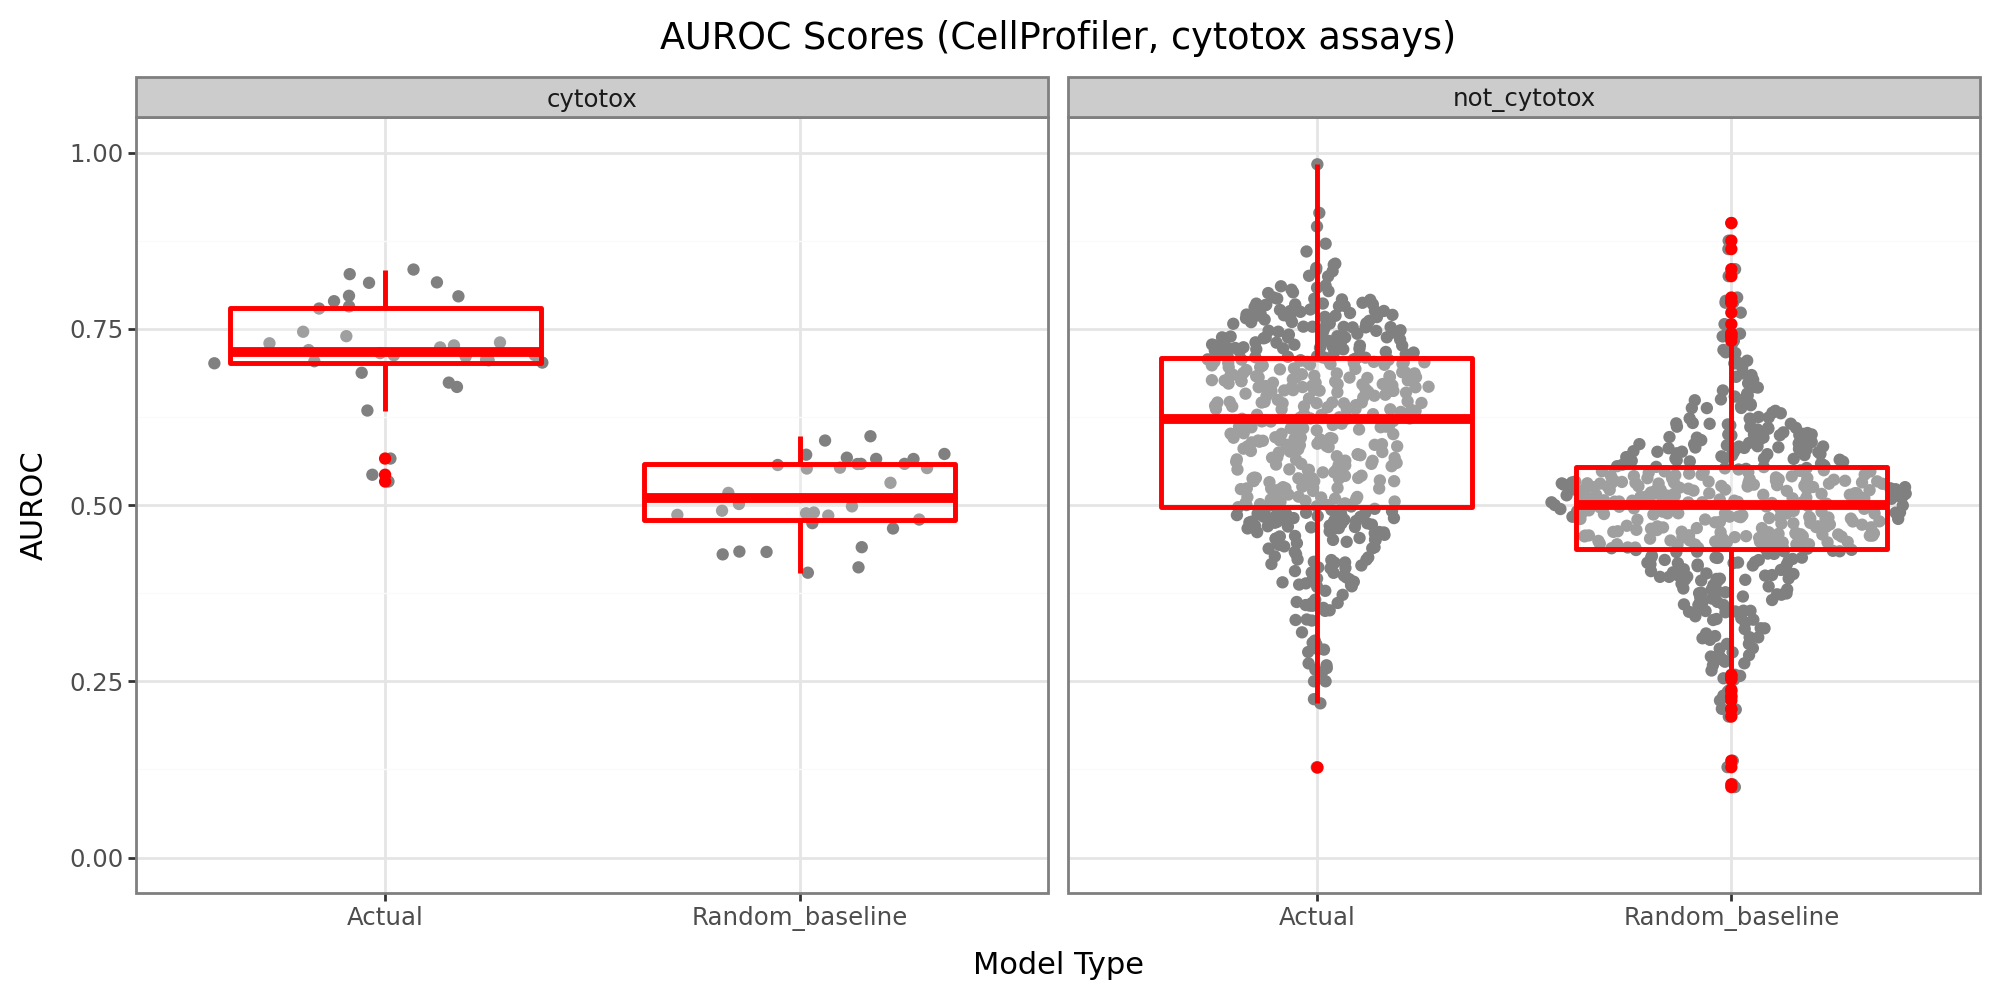

In [7]:
seal_all_cytotox = seal_cellprofiler.filter(pl.col("Metadata_AggType") == "all").with_columns(
    pl.when(pl.col("Metadata_Label").is_in(cytotox)).then(pl.lit("cytotox")).otherwise(pl.lit("not_cytotox")).alias("Cytotox")
)

plot = (
    ggplot(seal_all_cytotox, aes(x='Model_type', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + ylim(0,1)
    + facet_wrap("Cytotox", ncol=5)
    + labs(title='AUROC Scores (CellProfiler, cytotox assays)', x='Model Type', y='AUROC') 
    + theme_bw()
)
plot.show()

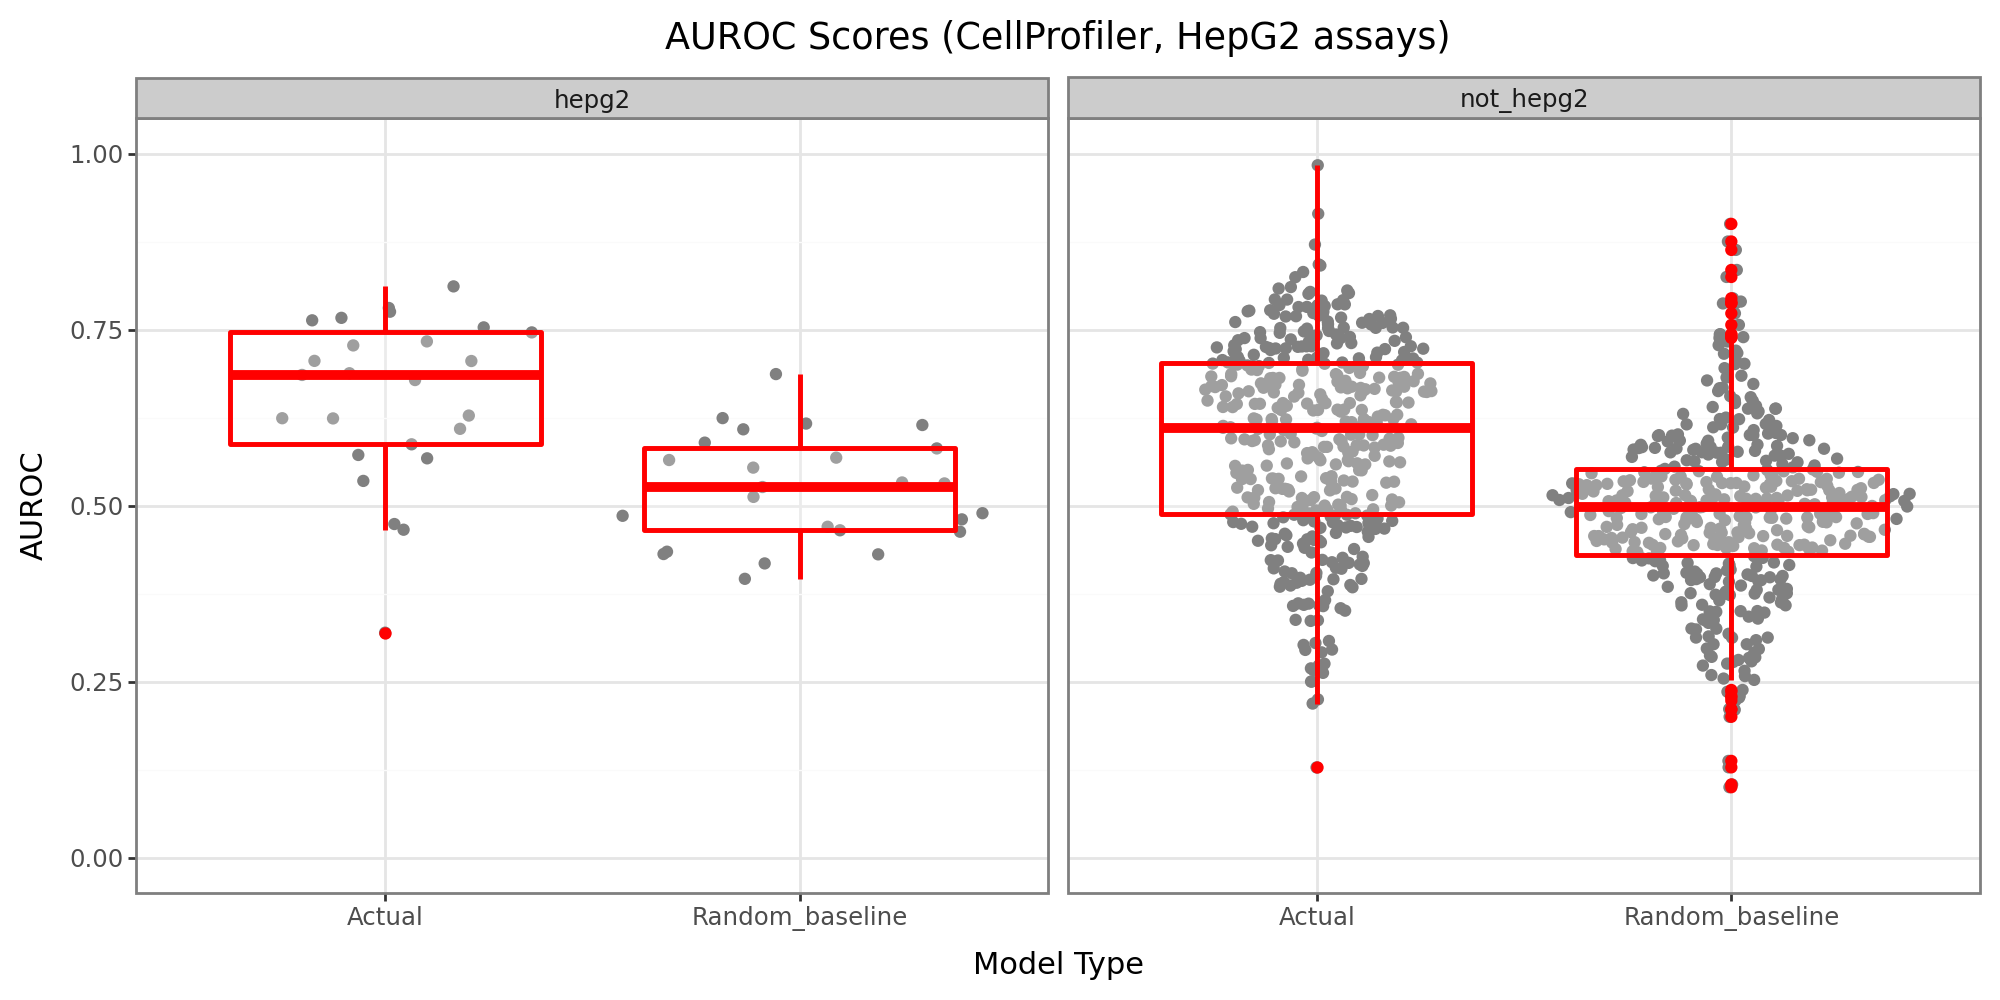

In [10]:
seal_all_hepg2 = seal_cellprofiler.filter(pl.col("Metadata_AggType") == "all").filter(pl.col("Metadata_Label").is_in(not_cytotox)).with_columns(
    pl.when(pl.col("Metadata_Label").is_in(hepg2)).then(pl.lit("hepg2")).otherwise(pl.lit("not_hepg2")).alias("HepG2")
)

plot = (
    ggplot(seal_all_hepg2, aes(x='Model_type', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + ylim(0,1)
    + facet_wrap("HepG2", ncol=5)
    + labs(title='AUROC Scores (CellProfiler, HepG2 assays)', x='Model Type', y='AUROC') 
    + theme_bw()
)
plot.show()

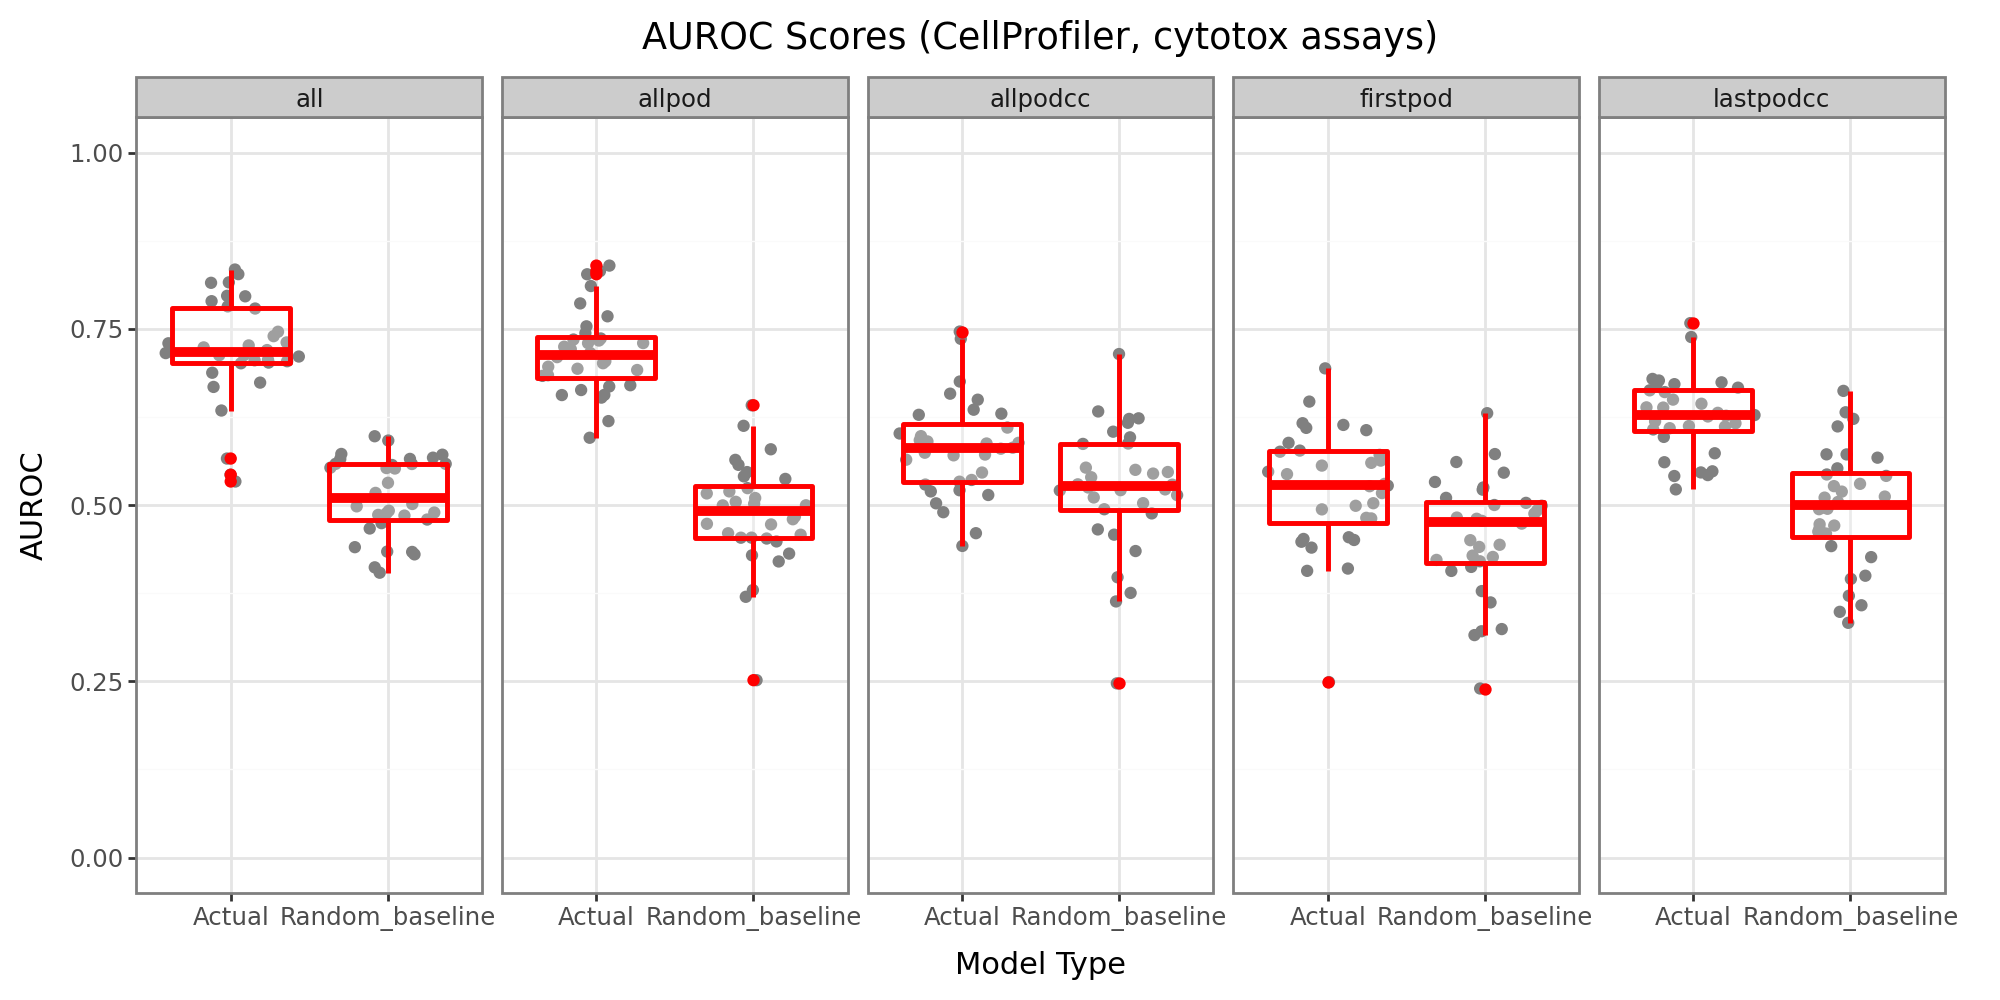

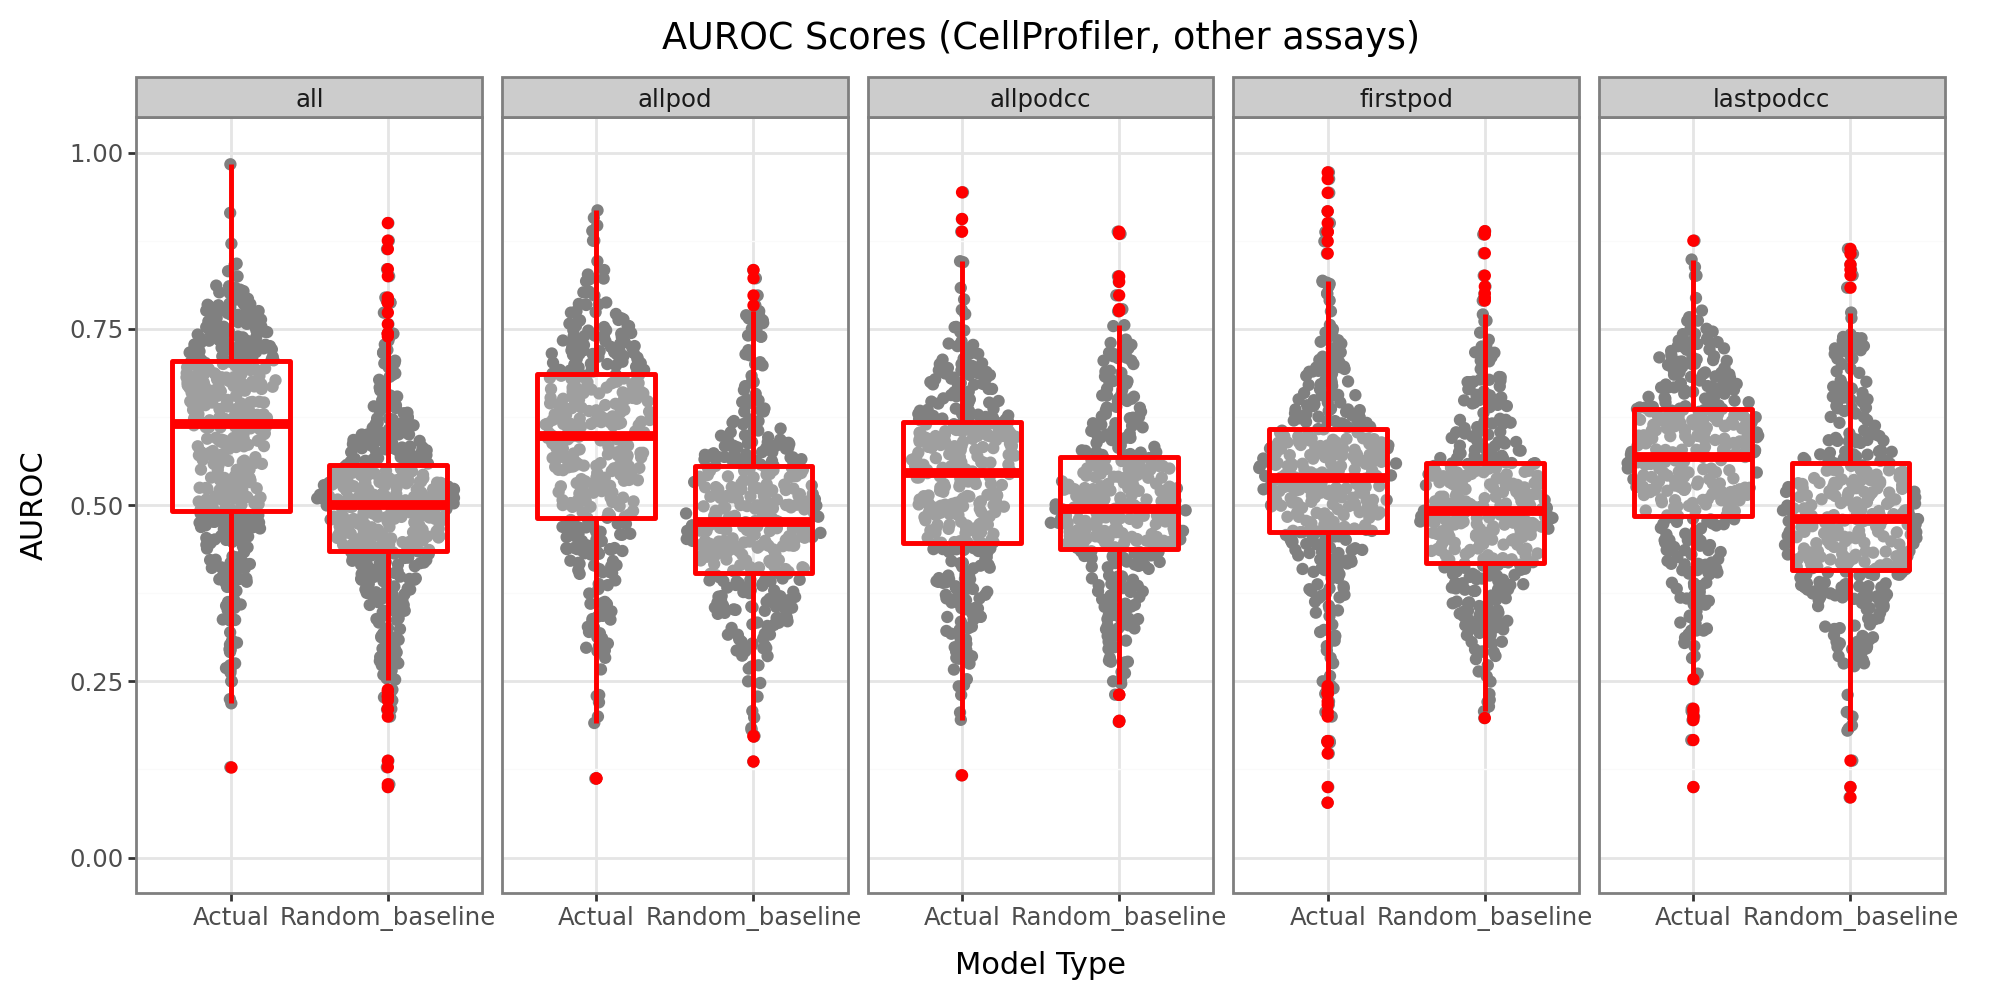

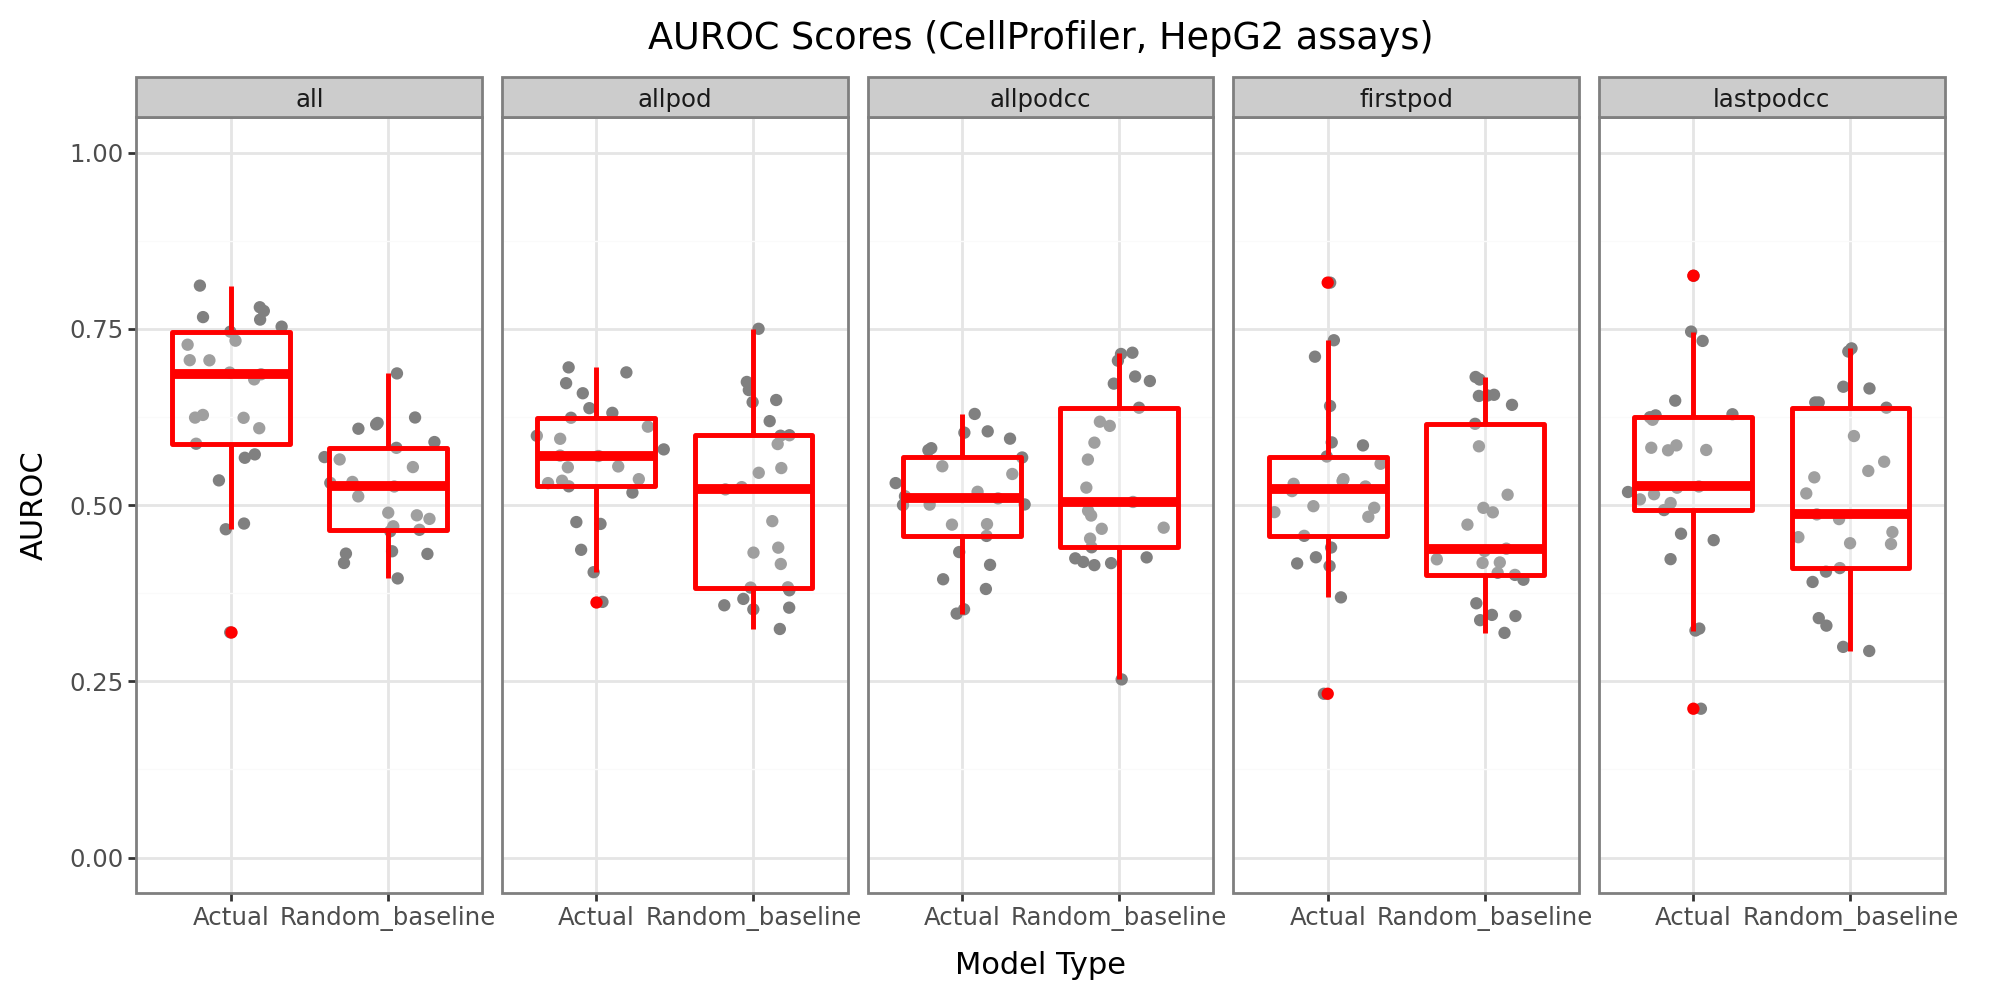

In [5]:
from plotnine import ggplot, aes, geom_sina, geom_boxplot, labs, theme_bw, position_dodge, facet_wrap, ylim
import plotnine as pn

pn.options.figure_size = (10, 5)

plot = (
    ggplot(cellprofiler_cytotox, aes(x='Model_type', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + ylim(0,1)
    + facet_wrap("Metadata_AggType", ncol=5)
    + labs(title='AUROC Scores (CellProfiler, cytotox assays)', x='Model Type', y='AUROC') 
    + theme_bw()
)
plot.show()

plot = (
    ggplot(cellprofiler_other, aes(x='Model_type', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + ylim(0,1)
    + facet_wrap("Metadata_AggType", ncol=5)
    + labs(title='AUROC Scores (CellProfiler, other assays)', x='Model Type', y='AUROC') 
    + theme_bw()
)
plot.show()

plot = (
    ggplot(cellprofiler_hepg2, aes(x='Model_type', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + ylim(0,1)
    + facet_wrap("Metadata_AggType", ncol=5)
    + labs(title='AUROC Scores (CellProfiler, HepG2 assays)', x='Model Type', y='AUROC') 
    + theme_bw()
)
plot.show()

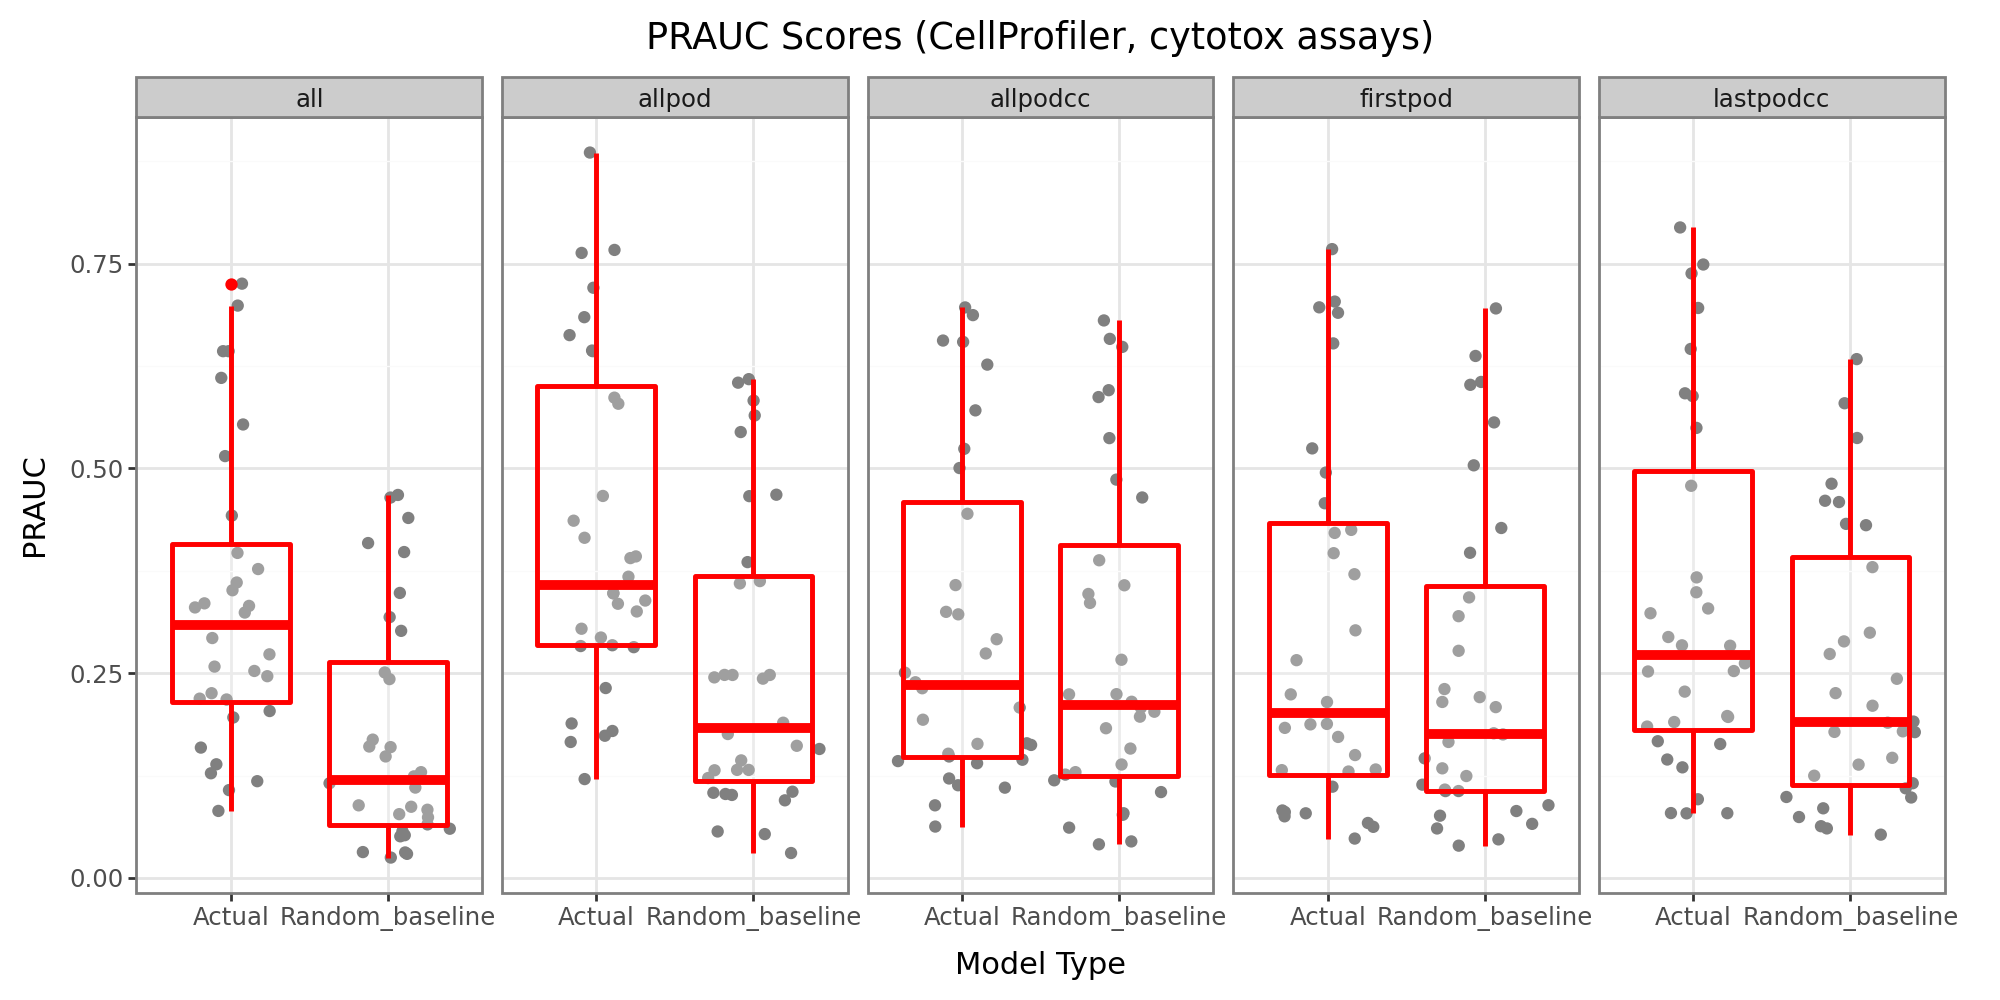

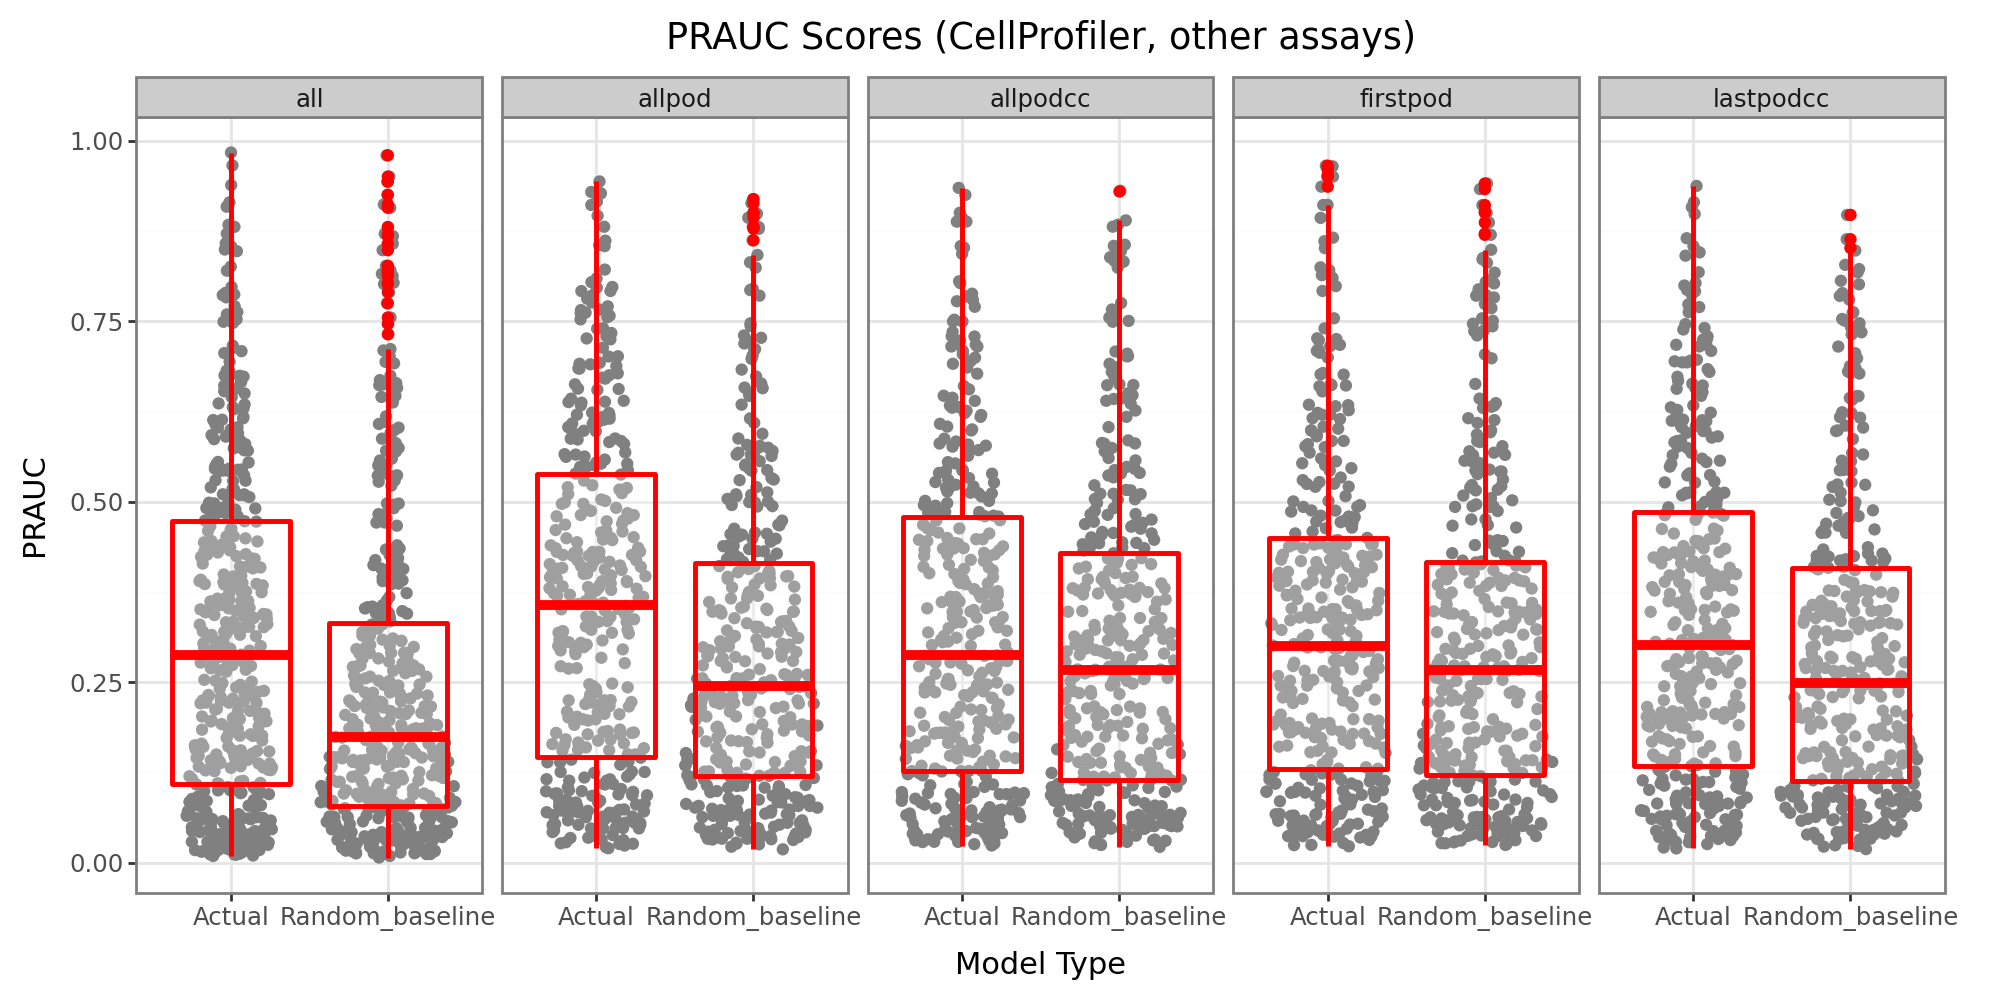

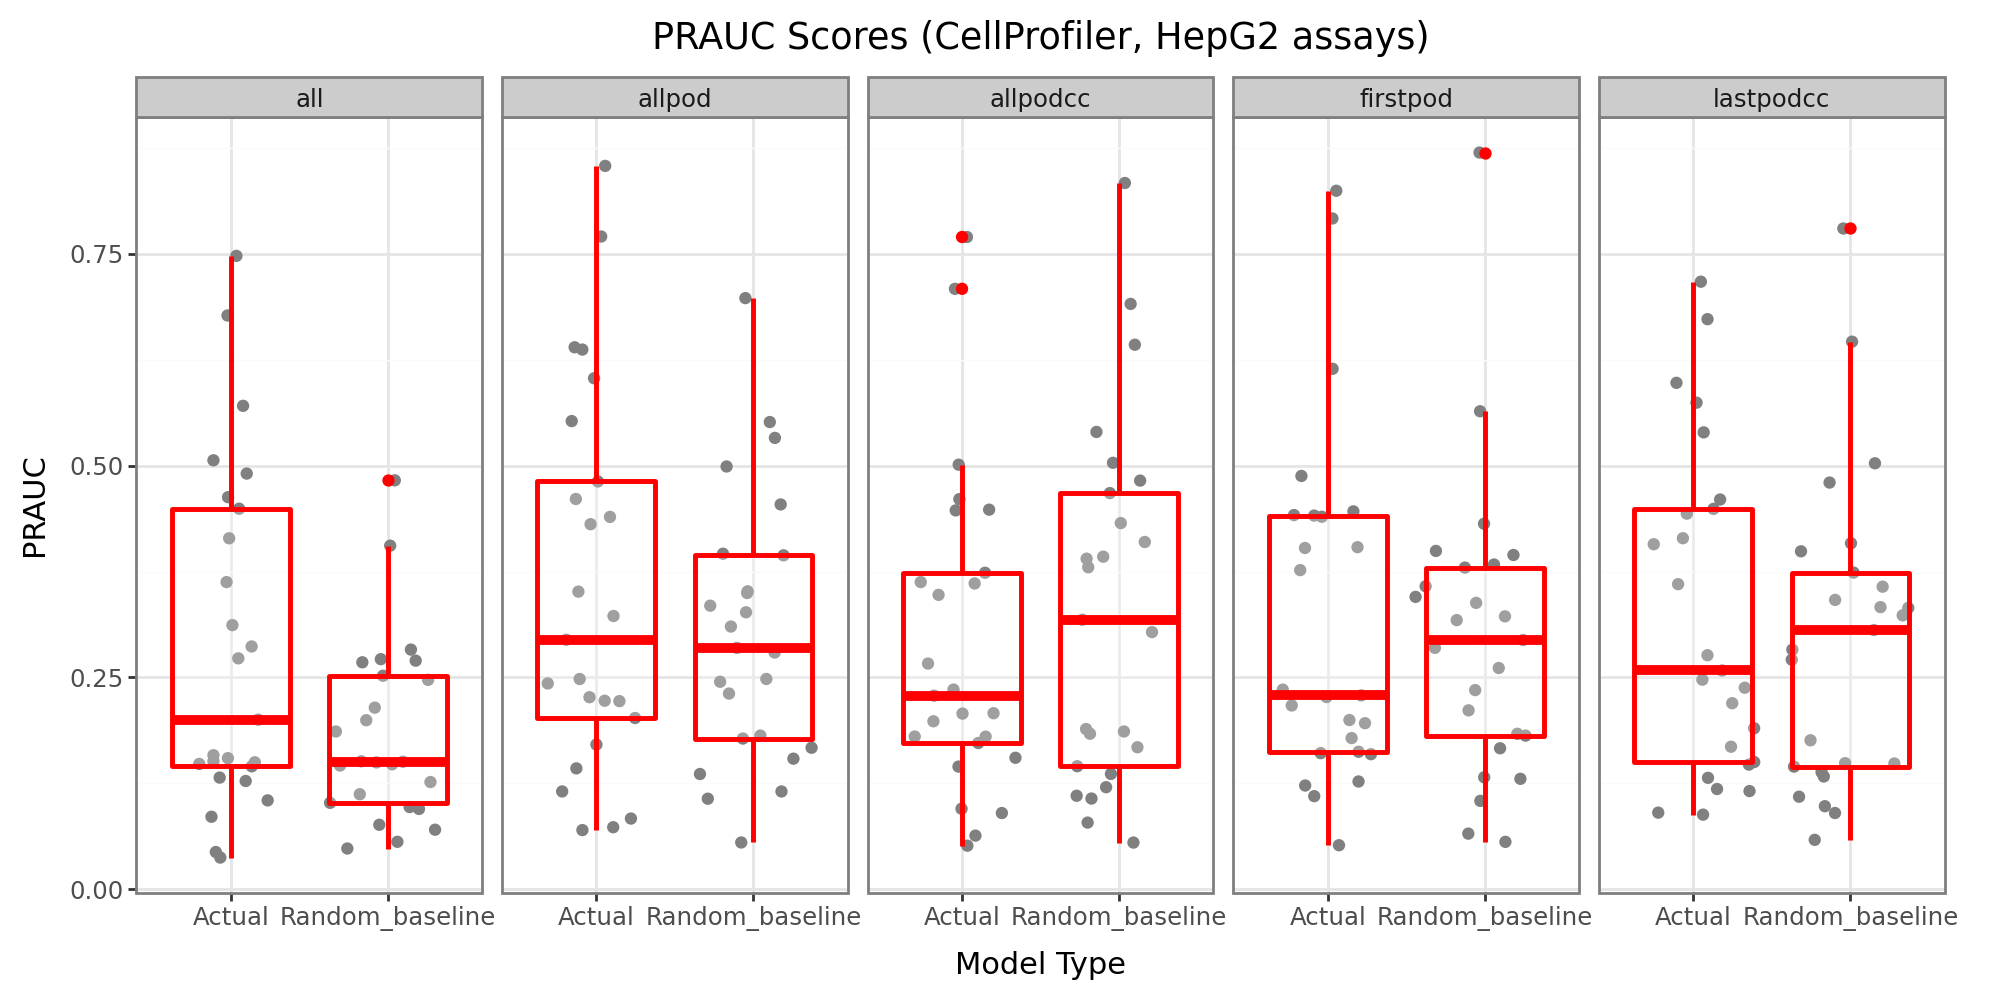

In [15]:
from plotnine import ggplot, aes, geom_sina, geom_boxplot, labs, theme_bw, position_dodge, facet_wrap
import plotnine as pn

pn.options.figure_size = (10, 5)

plot = (
    ggplot(cellprofiler_cytotox, aes(x='Model_type', y='PRAUC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + facet_wrap("Metadata_AggType", ncol=5)
    + labs(title='PRAUC Scores (CellProfiler, cytotox assays)', x='Model Type', y='PRAUC') 
    + theme_bw()
)
plot.show()

plot = (
    ggplot(cellprofiler_other, aes(x='Model_type', y='PRAUC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + facet_wrap("Metadata_AggType", ncol=5)
    + labs(title='PRAUC Scores (CellProfiler, other assays)', x='Model Type', y='PRAUC') 
    + theme_bw()
)
plot.show()

plot = (
    ggplot(cellprofiler_hepg2, aes(x='Model_type', y='PRAUC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + facet_wrap("Metadata_AggType", ncol=5)
    + labs(title='PRAUC Scores (CellProfiler, HepG2 assays)', x='Model Type', y='PRAUC') 
    + theme_bw()
)
plot.show()

In [49]:
hepg2

['Toxcast_APR_HepG2_MicrotubuleCSK_24h_up',
 'Toxcast_APR_HepG2_MitoMass_72h_dn',
 'Toxcast_APR_HepG2_StressKinase_72h_up',
 'Toxcast_APR_HepG2_CellLoss_72h_dn',
 'Toxcast_APR_HepG2_CellCycleArrest_24h_dn',
 'Toxcast_APR_HepG2_NuclearSize_72h_up',
 'Toxcast_APR_HepG2_MitoMembPot_24h_dn',
 'Toxcast_APR_HepG2_p53Act_24h_up',
 'Toxcast_APR_HepG2_MitoMembPot_72h_dn',
 'Toxcast_APR_HepG2_MitoMembPot_1h_dn',
 'Toxcast_APR_HepG2_NuclearSize_24h_dn',
 'Toxcast_APR_HepG2_CellCycleArrest_24h_up',
 'Toxcast_APR_HepG2_CellCycleArrest_72h_dn',
 'Toxcast_APR_HepG2_MitoMass_72h_up',
 'Toxcast_APR_HepG2_MitoticArrest_24h_up',
 'Toxcast_APR_HepG2_MitoticArrest_72h_up',
 'Toxcast_APR_HepG2_CellLoss_24h_dn',
 'Toxcast_APR_HepG2_MicrotubuleCSK_72h_dn',
 'Toxcast_APR_HepG2_MicrotubuleCSK_72h_up',
 'Toxcast_APR_HepG2_MitoMass_24h_dn',
 'Toxcast_APR_HepG2_MicrotubuleCSK_24h_dn',
 'Toxcast_APR_HepG2_p53Act_72h_up',
 'Toxcast_APR_HepG2_OxidativeStress_72h_up',
 'Toxcast_APR_HepG2_OxidativeStress_24h_up',
 'Tox

## Compute statistics

In [6]:
model = smf.mixedlm("AUROC ~ Metadata_AggType", seal_pandas, groups=seal_pandas["Metadata_Label"],
                    re_formula="~Feat_type")
result = model.fit()
seal_pandas["fitted_values"] = result.fittedvalues

mc = MultiComparison(seal_pandas["fitted_values"], seal_pandas["Metadata_AggType"])
tukey_result = mc.tukeyhsd()

tukey_pvals = tukey_result.pvalues
print(tukey_result.summary())
print(tukey_pvals)


/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.


   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1    group2  meandiff p-adj   lower   upper  reject
---------------------------------------------------------
     all    allpod  -0.0121    0.0 -0.0189 -0.0053   True
     all  allpodcc  -0.0591    0.0 -0.0659 -0.0522   True
     all  firstpod  -0.0698    0.0 -0.0766  -0.063   True
     all lastpodcc  -0.0577    0.0 -0.0646 -0.0509   True
  allpod  allpodcc   -0.047    0.0 -0.0541 -0.0398   True
  allpod  firstpod  -0.0577    0.0 -0.0648 -0.0506   True
  allpod lastpodcc  -0.0456    0.0 -0.0528 -0.0385   True
allpodcc  firstpod  -0.0108 0.0004 -0.0179 -0.0036   True
allpodcc lastpodcc   0.0013 0.9869 -0.0059  0.0085  False
firstpod lastpodcc   0.0121    0.0   0.005  0.0192   True
---------------------------------------------------------
[1.22259647e-05 3.46567219e-12 3.46567219e-12 3.46567219e-12
 3.46567219e-12 3.46567219e-12 3.46567219e-12 3.76681728e-04
 9.86876507e-01 3.74739549e-05]


In [7]:
model = smf.mixedlm("F1_Score ~ Metadata_AggType", seal_pandas, groups=seal_pandas["Metadata_Label"],
                    re_formula="~Feat_type")
result = model.fit()
seal_pandas["fitted_values"] = result.fittedvalues

mc = MultiComparison(seal_pandas["fitted_values"], seal_pandas["Metadata_AggType"])
tukey_result = mc.tukeyhsd()

tukey_pvals = tukey_result.pvalues
print(tukey_result.summary())
print(tukey_pvals)

/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.


   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1    group2  meandiff p-adj   lower   upper  reject
---------------------------------------------------------
     all    allpod   0.0106    0.0  0.0063  0.0148   True
     all  allpodcc  -0.0238    0.0 -0.0281 -0.0196   True
     all  firstpod  -0.0282    0.0 -0.0324  -0.024   True
     all lastpodcc  -0.0222    0.0 -0.0265  -0.018   True
  allpod  allpodcc  -0.0344    0.0 -0.0388   -0.03   True
  allpod  firstpod  -0.0388    0.0 -0.0432 -0.0344   True
  allpod lastpodcc  -0.0328    0.0 -0.0372 -0.0283   True
allpodcc  firstpod  -0.0044 0.0527 -0.0088     0.0  False
allpodcc lastpodcc   0.0016 0.8596 -0.0028  0.0061  False
firstpod lastpodcc    0.006  0.002  0.0016  0.0104   True
---------------------------------------------------------
[1.03622666e-10 3.46567219e-12 3.46567219e-12 3.46567219e-12
 3.46567219e-12 3.46567219e-12 3.46567219e-12 5.27218769e-02
 8.59550577e-01 1.96443037e-03]


In [8]:
model = smf.mixedlm("PRAUC ~ Metadata_AggType", seal_pandas, groups=seal_pandas["Metadata_Label"],
                    re_formula="~Feat_type")
result = model.fit()
seal_pandas["fitted_values"] = result.fittedvalues

mc = MultiComparison(seal_pandas["fitted_values"], seal_pandas["Metadata_AggType"])
tukey_result = mc.tukeyhsd()

tukey_pvals = tukey_result.pvalues
print(tukey_result.summary())
print(tukey_pvals)

/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.


   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1    group2  meandiff p-adj   lower   upper  reject
---------------------------------------------------------
     all    allpod   0.0181 0.0304  0.0011   0.035   True
     all  allpodcc  -0.0294    0.0 -0.0465 -0.0123   True
     all  firstpod  -0.0381    0.0  -0.055 -0.0211   True
     all lastpodcc  -0.0244  0.001 -0.0415 -0.0073   True
  allpod  allpodcc  -0.0475    0.0 -0.0653 -0.0297   True
  allpod  firstpod  -0.0561    0.0 -0.0738 -0.0385   True
  allpod lastpodcc  -0.0424    0.0 -0.0602 -0.0247   True
allpodcc  firstpod  -0.0087 0.6736 -0.0264  0.0091  False
allpodcc lastpodcc    0.005 0.9394 -0.0129   0.023  False
firstpod lastpodcc   0.0137 0.2184 -0.0041  0.0315  False
---------------------------------------------------------
[3.03574913e-02 2.73707636e-05 9.84197346e-09 9.73629851e-04
 6.86384283e-12 3.46589424e-12 7.67073738e-10 6.73578894e-01
 9.39385261e-01 2.18440293e-01]


## Motive outcomes

In [9]:
motive_preds = pl.read_parquet("./compiled_results/compiled_motive_metrics.parquet")
motive_pandas = motive_preds.to_pandas()

motive_cpcnn = motive_preds.filter(pl.col("Feat_type") == "cpcnn")
motive_dino = motive_preds.filter(pl.col("Feat_type") == "dino")
motive_cellprofiler = motive_preds.filter(pl.col("Feat_type") == "cellprofiler")

### CPCNN

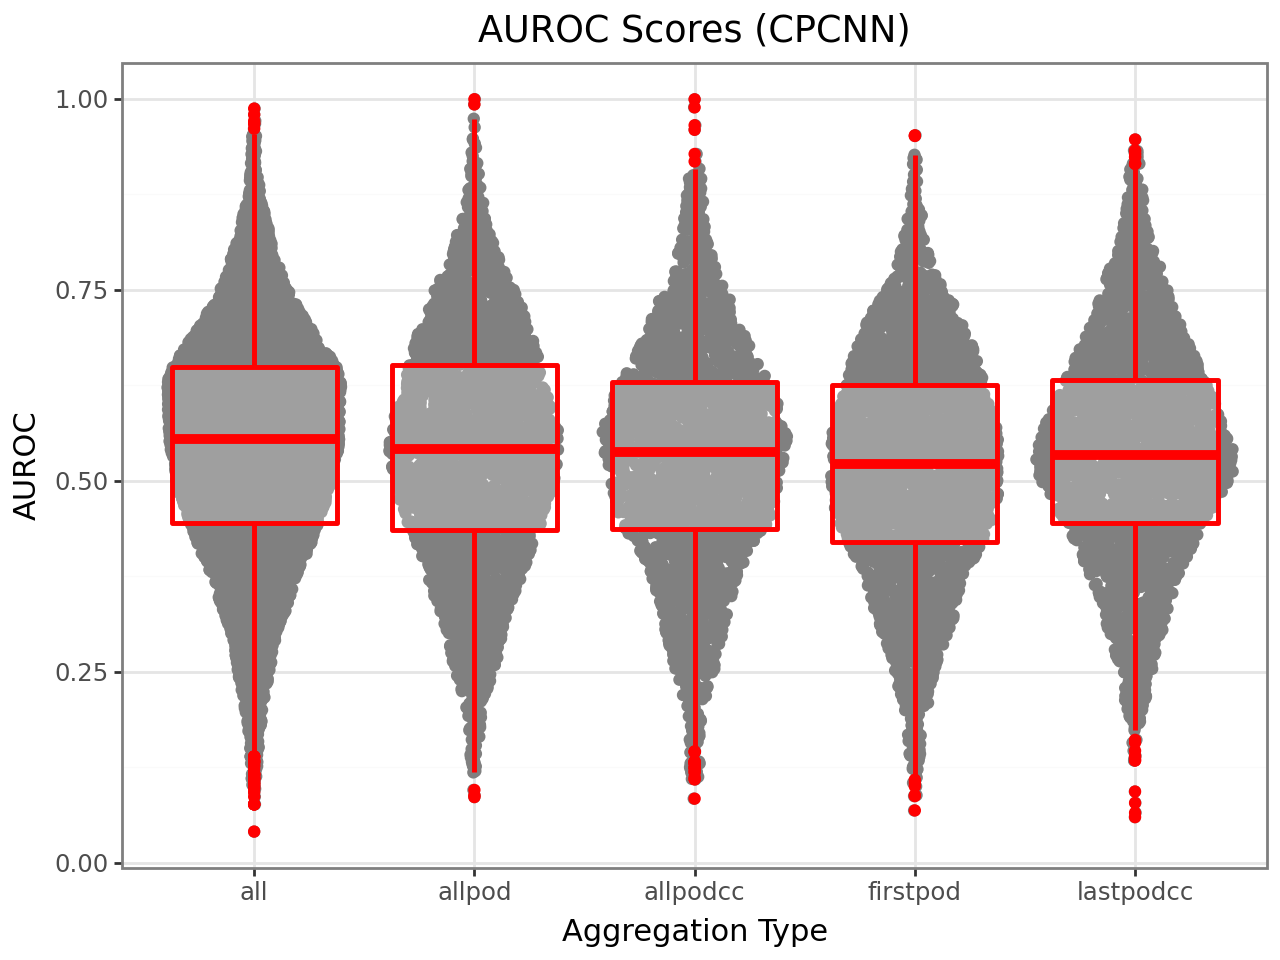

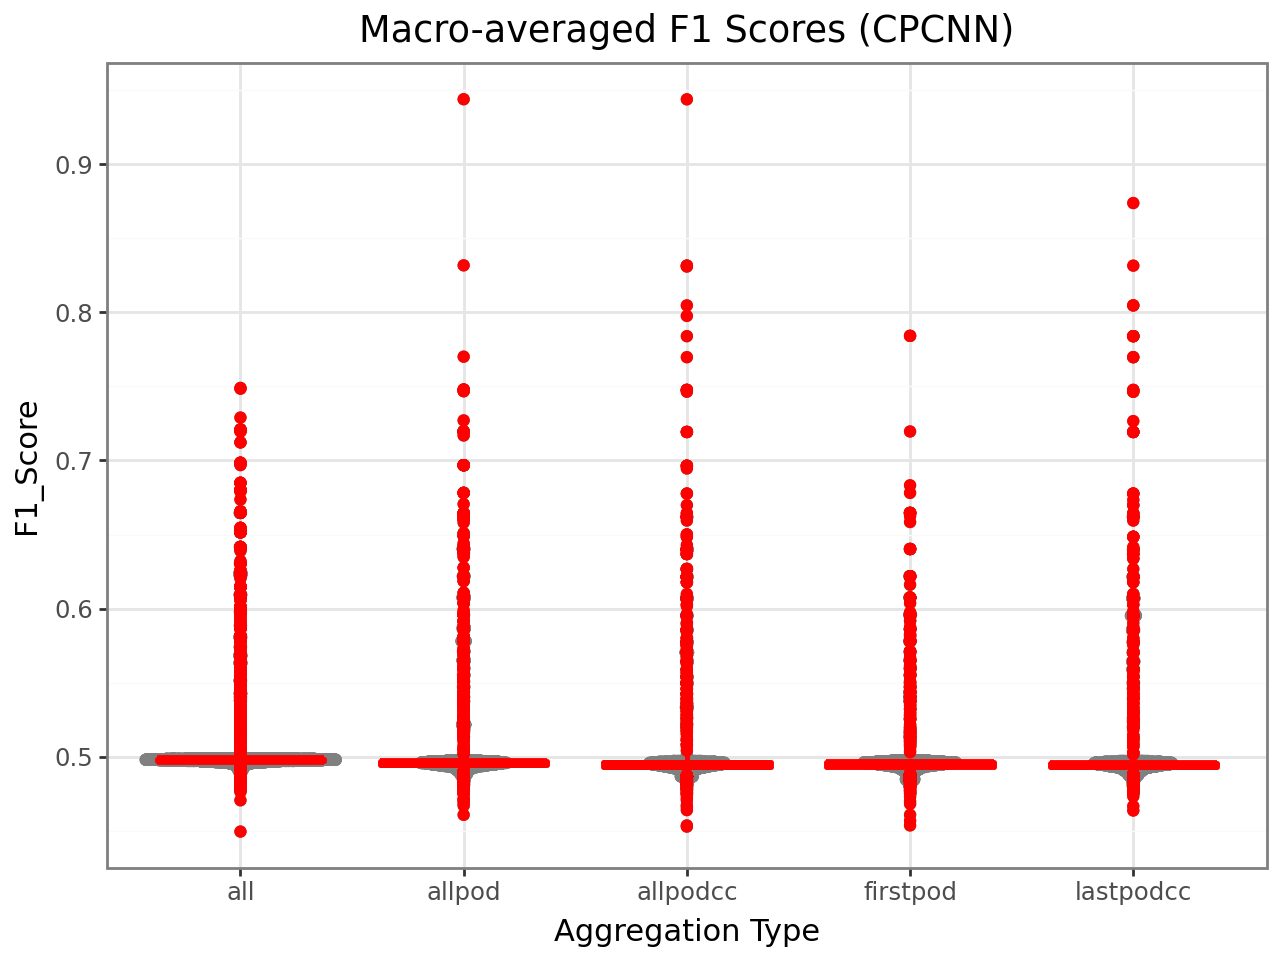

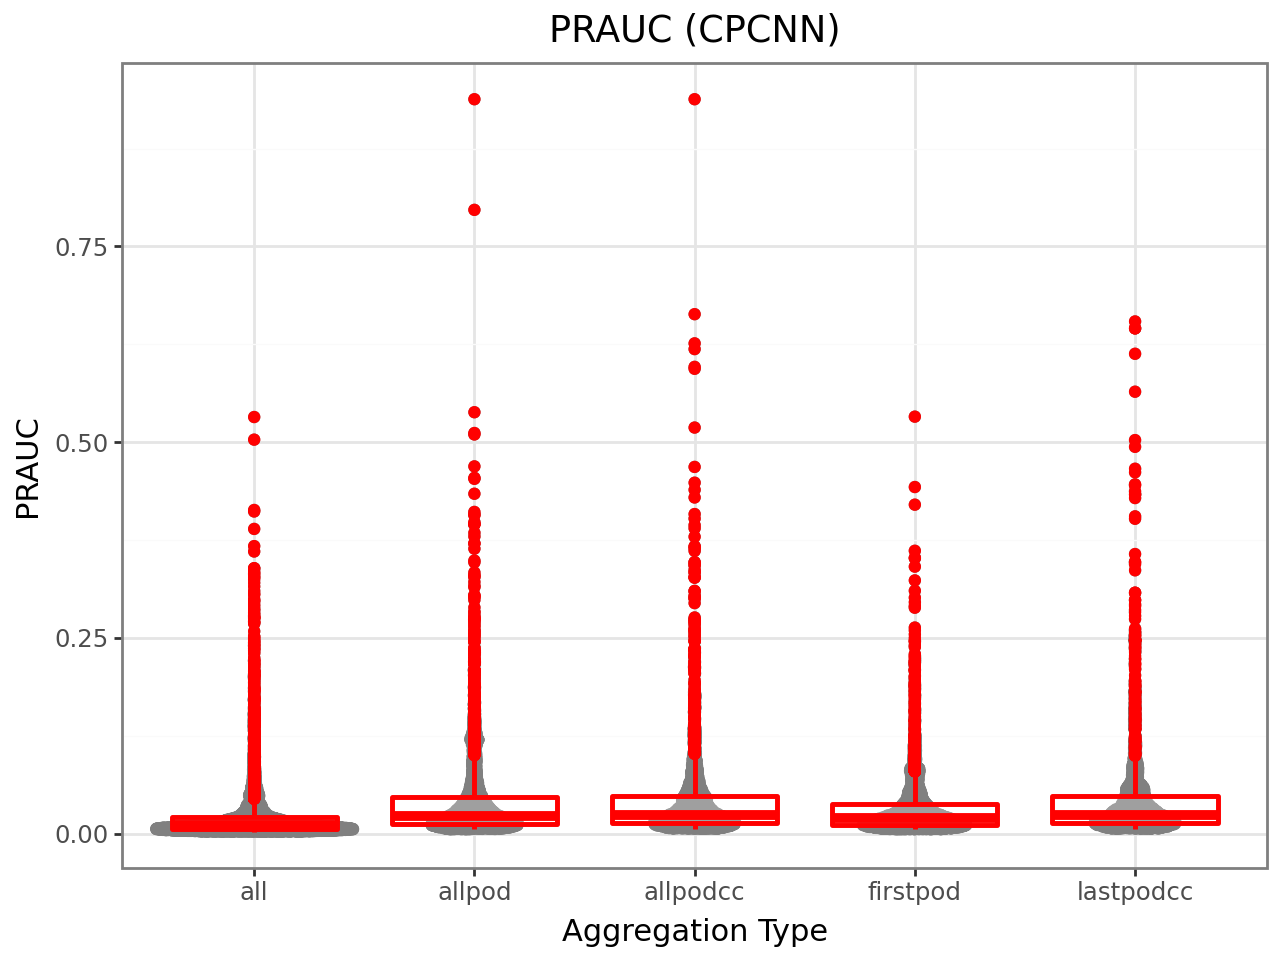

In [10]:
from plotnine import ggplot, aes, geom_sina, geom_boxplot, labs, theme_bw

plot = (
    ggplot(motive_cpcnn, aes(x='Metadata_AggType', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + labs(title='AUROC Scores (CPCNN)', x='Aggregation Type', y='AUROC') 
    + theme_bw()
)

plot.show()

plot = (
    ggplot(motive_cpcnn, aes(x='Metadata_AggType', y='F1_Score')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + labs(title='Macro-averaged F1 Scores (CPCNN)', x='Aggregation Type', y='F1_Score') 
    + theme_bw()
)

plot.show()

plot = (
    ggplot(motive_cpcnn, aes(x='Metadata_AggType', y='PRAUC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + labs(title='PRAUC (CPCNN)', x='Aggregation Type', y='PRAUC') 
    + theme_bw()
)

plot.show()

### Dino

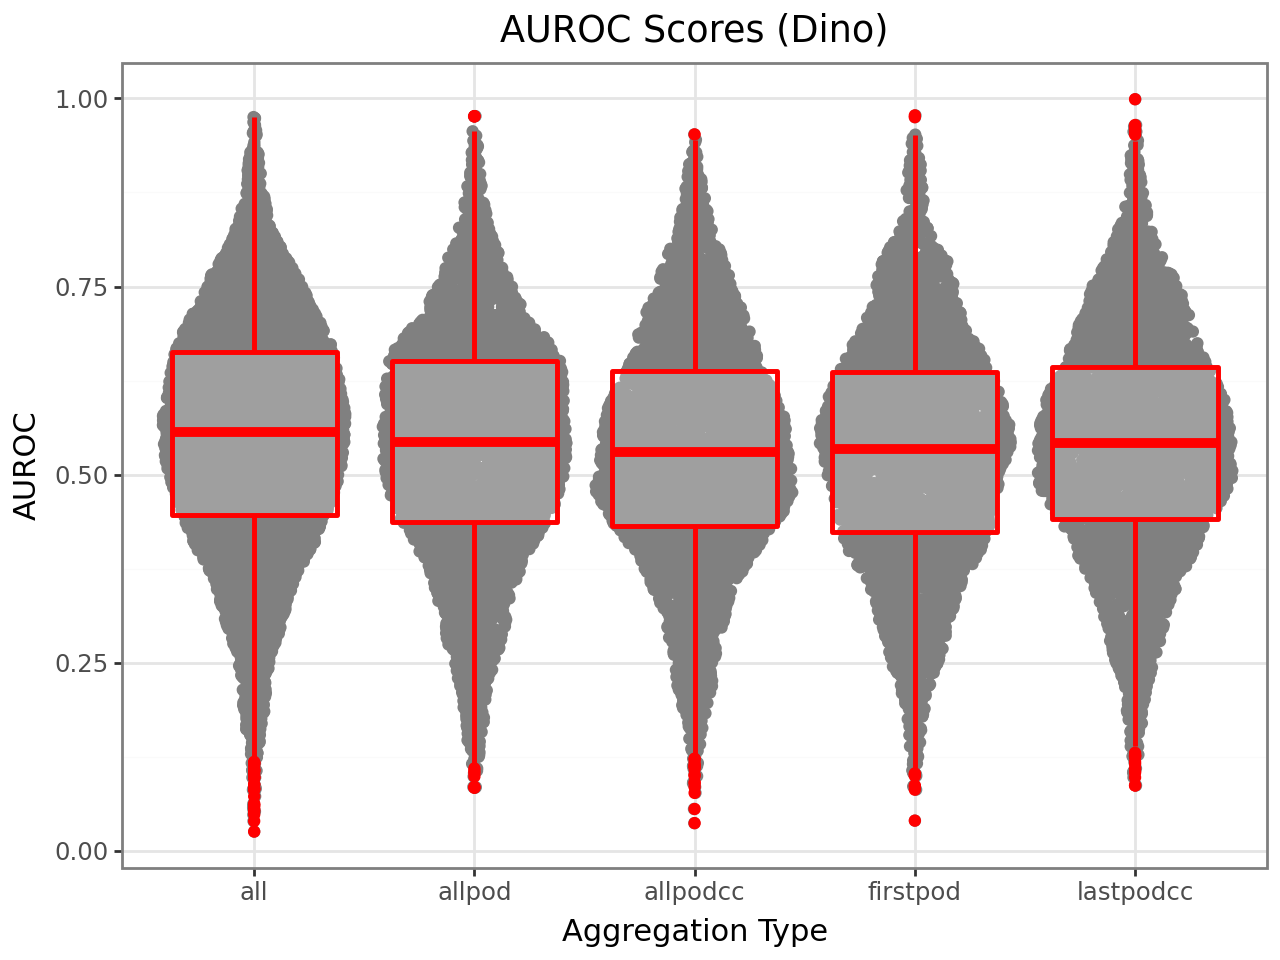

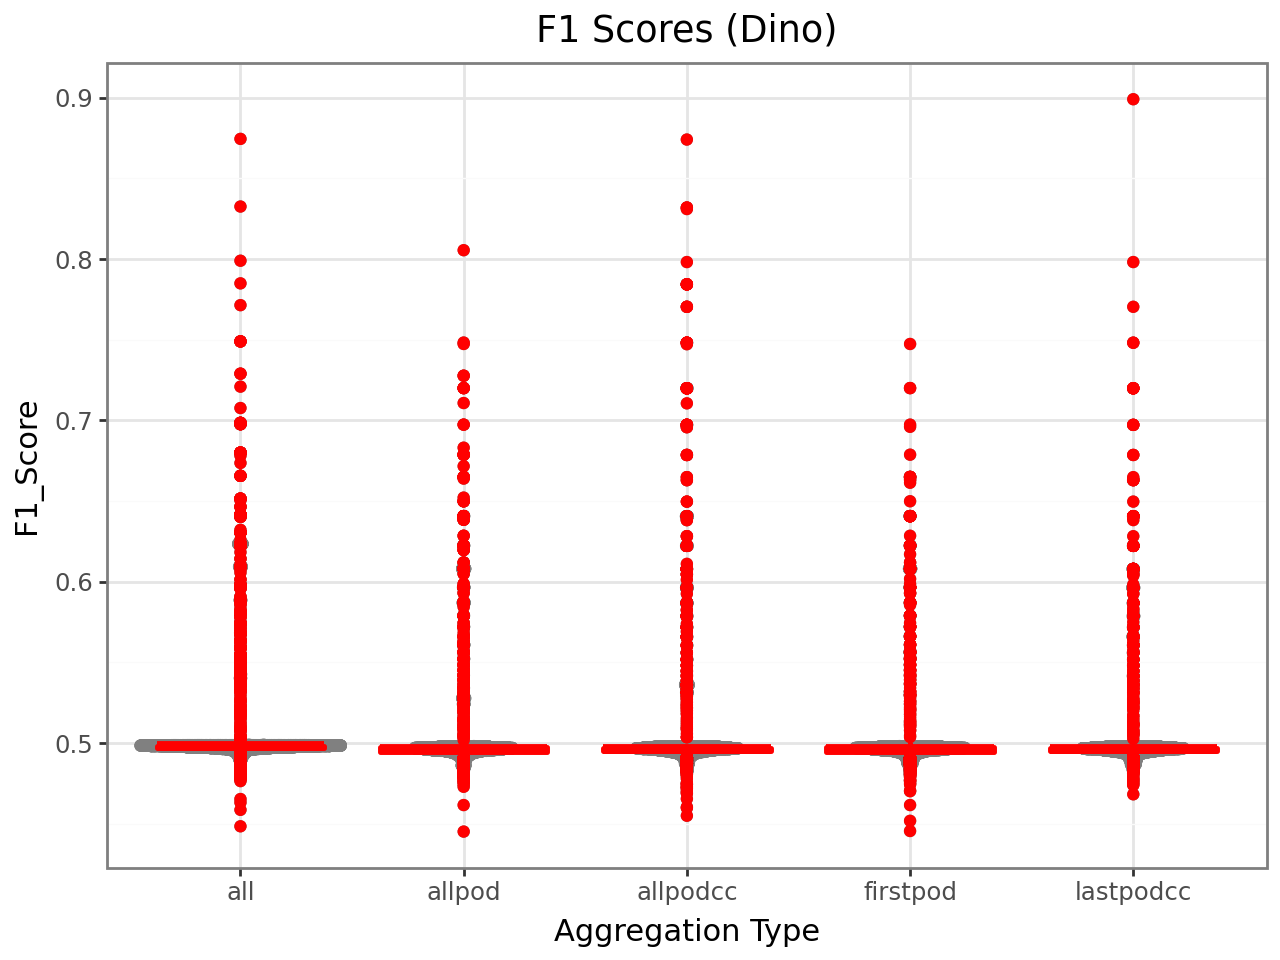

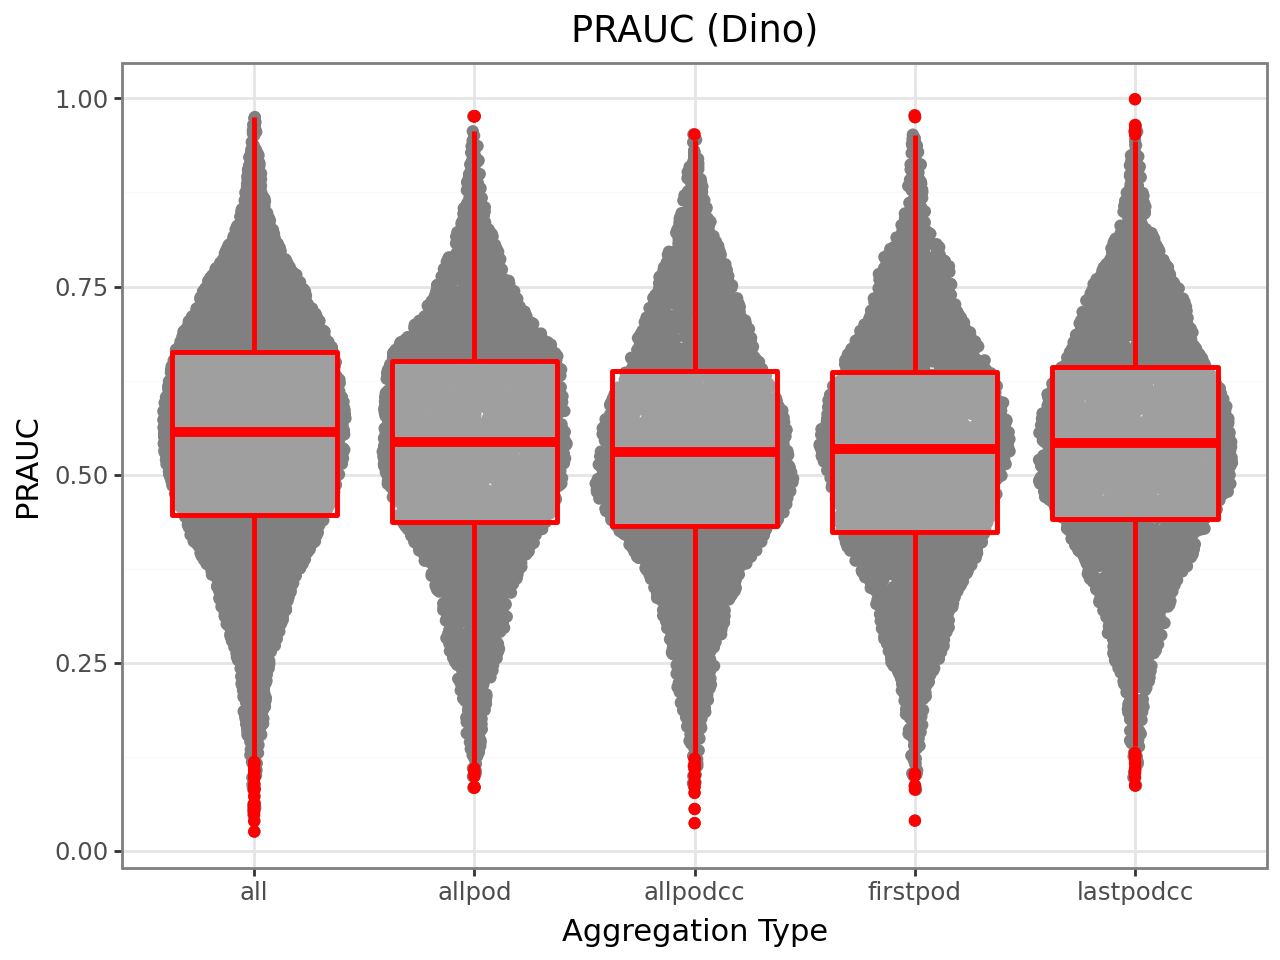

In [11]:
from plotnine import ggplot, aes, geom_boxplot, geom_sina, labs, theme_bw

plot = (
    ggplot(motive_dino, aes(x='Metadata_AggType', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + labs(title='AUROC Scores (Dino)', x='Aggregation Type', y='AUROC') 
    + theme_bw()
)
plot.show()

plot = (
    ggplot(motive_dino, aes(x='Metadata_AggType', y='F1_Score')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + labs(title='F1 Scores (Dino)', x='Aggregation Type', y='F1_Score') 
    + theme_bw()
)
plot.show()

plot = (
    ggplot(motive_dino, aes(x='Metadata_AggType', y='PRAUC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + labs(title='PRAUC (Dino)', x='Aggregation Type', y='PRAUC') 
    + theme_bw()
)
plot.show()

### CellProfiler

In [12]:
from plotnine import ggplot, aes, geom_boxplot, geom_sina, labs, theme_bw

plot = (
    ggplot(motive_cellprofiler, aes(x='Metadata_AggType', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + labs(title='AUROC Scores (CellProfiler)', x='Aggregation Type', y='AUROC') 
    + theme_bw()
)
plot.show()

plot = (
    ggplot(motive_cellprofiler, aes(x='Metadata_AggType', y='F1_Score')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + labs(title='F1 Scores (CellProfiler)', x='Aggregation Type', y='F1_Score') 
    + theme_bw()
)
plot.show()

plot = (
    ggplot(motive_cellprofiler, aes(x='Metadata_AggType', y='PRAUC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + labs(title='PRAUC (CellProfiler)', x='Aggregation Type', y='PRAUC') 
    + theme_bw()
)
plot.show()

KeyError: 'xmax'

### Statistical tests

In [13]:
model = smf.mixedlm("AUROC ~ Metadata_AggType", motive_pandas, groups=motive_pandas["Metadata_Label"],
                    re_formula="~Feat_type")
result = model.fit()
motive_pandas["fitted_values"] = result.fittedvalues

mc = MultiComparison(motive_pandas["fitted_values"], motive_pandas["Metadata_AggType"])
tukey_result = mc.tukeyhsd()

tukey_pvals = tukey_result.pvalues
print(tukey_result.summary())
print(tukey_pvals)

/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.


   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1    group2  meandiff p-adj   lower   upper  reject
---------------------------------------------------------
     all    allpod  -0.0083    0.0 -0.0112 -0.0054   True
     all  allpodcc   -0.016    0.0  -0.019  -0.013   True
     all  firstpod  -0.0218    0.0 -0.0247 -0.0188   True
     all lastpodcc  -0.0091    0.0 -0.0121 -0.0061   True
  allpod  allpodcc  -0.0077    0.0 -0.0112 -0.0042   True
  allpod  firstpod  -0.0135    0.0 -0.0169 -0.0101   True
  allpod lastpodcc  -0.0008 0.9718 -0.0043  0.0027  False
allpodcc  firstpod  -0.0057 0.0001 -0.0093 -0.0022   True
allpodcc lastpodcc   0.0069    0.0  0.0033  0.0105   True
firstpod lastpodcc   0.0127    0.0  0.0092  0.0162   True
---------------------------------------------------------
[3.57225360e-12 3.48210349e-12 3.48210349e-12 3.48510110e-12
 2.16644139e-08 3.48210349e-12 9.71841137e-01 8.09918708e-05
 1.77156012e-06 3.48210349e-12]


In [14]:
model = smf.mixedlm("F1_Score ~ Metadata_AggType", motive_pandas, groups=motive_pandas["Metadata_Label"],
                    re_formula="~Feat_type")
result = model.fit()
motive_pandas["fitted_values"] = result.fittedvalues

mc = MultiComparison(motive_pandas["fitted_values"], motive_pandas["Metadata_AggType"])
tukey_result = mc.tukeyhsd()

tukey_pvals = tukey_result.pvalues
print(tukey_result.summary())
print(tukey_pvals)

/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.


   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1    group2  meandiff p-adj   lower   upper  reject
---------------------------------------------------------
     all    allpod   0.0019    0.0  0.0013  0.0025   True
     all  allpodcc   0.0019    0.0  0.0013  0.0025   True
     all  firstpod  -0.0029    0.0 -0.0035 -0.0024   True
     all lastpodcc  -0.0001 0.9881 -0.0007  0.0005  False
  allpod  allpodcc     -0.0    1.0 -0.0007  0.0007  False
  allpod  firstpod  -0.0048    0.0 -0.0055 -0.0041   True
  allpod lastpodcc   -0.002    0.0 -0.0027 -0.0013   True
allpodcc  firstpod  -0.0048    0.0 -0.0055 -0.0041   True
allpodcc lastpodcc   -0.002    0.0 -0.0027 -0.0013   True
firstpod lastpodcc   0.0028    0.0  0.0021  0.0035   True
---------------------------------------------------------
[3.48210349e-12 3.48221452e-12 3.48210349e-12 9.88122839e-01
 9.99999921e-01 3.48210349e-12 3.51618734e-12 3.48210349e-12
 3.69793085e-12 3.48210349e-12]


In [15]:
model = smf.mixedlm("PRAUC ~ Metadata_AggType", motive_pandas, groups=motive_pandas["Metadata_Label"],
                    re_formula="~Feat_type")
result = model.fit()
motive_pandas["fitted_values"] = result.fittedvalues

mc = MultiComparison(motive_pandas["fitted_values"], motive_pandas["Metadata_AggType"])
tukey_result = mc.tukeyhsd()

tukey_pvals = tukey_result.pvalues
print(tukey_result.summary())
print(tukey_pvals)

/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.


  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1    group2  meandiff p-adj   lower  upper  reject
--------------------------------------------------------
     all    allpod   0.0417    0.0  0.0316 0.0517   True
     all  allpodcc   0.0417    0.0  0.0312 0.0521   True
     all  firstpod   0.0323    0.0  0.0222 0.0423   True
     all lastpodcc   0.0459    0.0  0.0354 0.0563   True
  allpod  allpodcc      0.0    1.0 -0.0121 0.0122  False
  allpod  firstpod  -0.0094 0.1919 -0.0212 0.0024  False
  allpod lastpodcc   0.0042  0.879 -0.0079 0.0163  False
allpodcc  firstpod  -0.0094 0.2139 -0.0215 0.0027  False
allpodcc lastpodcc   0.0042 0.8921 -0.0083 0.0166  False
firstpod lastpodcc   0.0136 0.0193  0.0014 0.0257   True
--------------------------------------------------------
[3.48210349e-12 3.48210349e-12 3.48221452e-12 3.48210349e-12
 9.99999999e-01 1.91867383e-01 8.79040821e-01 2.13857438e-01
 8.92056415e-01 1.92793289e-02]
